# Comparing proportions

## Introduction

This chapter embarks on an exploration of the methodologies and Python tools that empower us to analyze and interpret scenarios where outcomes are classified into **categories**. Whether we're investigating the prevalence of a disease, the effectiveness of a treatment, or the association between risk factors and outcomes, the comparison of proportions provides a statistical lens through which we can discern meaningful relationships.

Proportions, representing the _fraction of individuals or events falling into specific categories_, offer a concise and intuitive way to summarize categorical data. The comparison of proportions extends this simplicity to uncover potential disparities or associations. By examining the **differences or ratios** between proportions derived from distinct groups or conditions, we gain insights into:

- Disease prevalence: how does the occurrence of a condition vary across populations or over time?
- Treatment efficacy: does a new intervention lead to a higher proportion of successful outcomes compared to a standard treatment or a control group?
- Risk factor analysis: is there a correlation between exposure to certain factors and the likelihood of developing a specific health outcome?
- Trend assessment: does the proportion of individuals exhibiting a particular trait change systematically across ordered categories (e.g., dosage levels in toxicology)?

We will go through a versatile toolkit for comparing proportions, leveraging the capabilities of Python to perform robust analyses:

- Contingency tables: the foundation for **organizing and visualizing** categorical relationships.
- Fisher's Exact test: the go-to for _small sample sizes_ when comparing proportions.
- Chi-Squared test: a powerful workhorse for _larger samples_, assessing the significance of observed differences.
- Cochran-Armitage trend test: a specialized tool for detecting trends in proportions across **ordered categories** - particularly relevant in toxicology studies.
- Case-control studies: a retrospective approach that investigates if past exposures are more common among individuals with a disease compared to those without.

(fisher)=
## Fisher's exact test

The core idea of Fisher's test is to calculate the probability of obtaining the exact distribution of the data (or one more extreme) if there were truly no association between the variables (the null hypothesis H0). It does this by considering all possible ways the data could be arranged while keeping the row and column totals fixed. This allows for a precise P value calculation, even when other tests might falter.

### When to use Fisher's test

When dealing with categorical data in biostatistics, we often find ourselves in situations where sample sizes are limited. This is where Fisher's exact test shines. Unlike other tests that rely on approximations (which may not be accurate with small samples), Fisher's test provides an exact calculation of the probability of observing the data (or something more extreme) under the null hypothesis of no association.

Fisher's test is particularly well-suited for:

- Small sample sizes: if the contingency table has cells with expected counts less than 5, Fisher's test is often the preferred choice.
- Rare events: when we're dealing with outcomes that occur infrequently, Fisher's test is more reliable than tests that rely on large-sample assumptions.
- 2x2 tables: while Fisher's test can be extended to larger tables, it's most commonly used for situations with two categorical variables, each having two levels (e.g., treatment vs. control, success vs. failure).

### Contingency table

A contingency table is a structured way to organize the results of a study where both the predictor (e.g., treatment or exposure) and the outcome are categorical. Rows typically correspond to the different levels of the predictor, while columns represent the different possible outcomes. The values within the table show the **count** of subjects falling into each combination of predictor and outcome. We can use [`scipy.stats.contingency` functions](https://docs.scipy.org/doc/scipy/reference/stats.contingency.html) or [`pandas.crosstab`](https://pandas.pydata.org/docs/reference/api/pandas.crosstab.html) to create and analyze contingency tables.

In [ ]:
import numpy as np
from scipy.stats import contingency

# Example data
treatment = np.array([1, 1, 2, 2, 1, 2, 1]) # 1 = Drug A, 2 = Drug B
outcome   = np.array([0, 1, 0, 1, 1, 1, 0]) # 0 = No response, 1 = Response


# Create contingency table with scipy.stats.contingency
res = contingency.crosstab(treatment, outcome) # treatment will be the rows, outcome the columns

print("With `scipy.stats.contingency`")
print("------------------------------")
print(f"The object containing all atributes is:\n{res}")
print(f"The `treatment` (rows) elements are: {res.elements[0]}") # type: ignore
print(f"The `outcome` (columns) elements are: {res.elements[1]}") # type: ignore
print(f"The actual contingency table is:\n{res.count}")

# If the data is already in a Pandas DataFrame we can use pandas.crosstab
import pandas as pd

# Assuming the Dataframe has columns named "treatment" and "outcome"
df = pd.DataFrame({"treatment": treatment, "outcome": outcome})


# Creating contingency table using pd.crosstab
table = pd.crosstab(
    df["treatment"].dropna(),  # Remove NaN values if expected
    df["outcome"],
    margins=True,     # Include row and column totals
    dropna=False      # Keep rows/columns with zero counts
)

print("\n\nWith `pandas.crosstab`")
print("----------------------")
print(table)

With `scipy.stats.contingency`
------------------------------
The object containing all atributes is:
CrosstabResult(elements=(array([1, 2]), array([0, 1])), count=array([[2, 2],
       [1, 2]]))
The `treatment` (rows) elements are: [1 2]
The `outcome` (columns) elements are: [0 1]
The actual contingency table is:
[[2 2]
 [1 2]]


With `pandas.crosstab`
----------------------
outcome    0  1  All
treatment           
1          2  2    4
2          1  2    3
All        3  4    7


Let's prepare the data derived from the study from [Agnelli and colleagues](https://pubmed.ncbi.nlm.nih.gov/23216615/), and where each value is an actual number of patients, in a contingency table.

| Treatment        | Recurrent VTE | No recurrence | Total |
| ---------------- | ------------- | ------------- | ----- |
| Placebo          |       73      |      756      |  829  |
| Apixaban, 2.5 mg |       14      |      826      |  840  |
| Total            |       87      |     1582      | 1669  |

The goal of this analysis is to draw conclusions about the _general population_ of patients who have experienced a thromboembolism. This is achieved by calculating confidence intervals (CIs) and a P value. The P value helps us answer a critical question: if the treatment truly doesn't affect the risk of recurrence (our null hypothesis, H0), what's the probability of observing incidence rates as different (or even more different) than what we see in our study, simply due to random chance?

The most appropriate statistical test for this situation is Fisher's exact test. However, Fisher's test can become computationally challenging with large sample sizes. In those cases, the [chi-square test](chi-squared) serves as a practical alternative, yielding nearly identical P values. The Fisher's exact test is performed with [`scipy.stats.fisher_exact`](https://docs.scipy.org/doc/scipy-1.13.1/reference/generated/scipy.stats.fisher_exact.html) on a 2x2 contingency table.

In [ ]:
# Contingency table with rows = alternative treatments, cols = alternative outcomes
# table = np.array([[73, 756], [14, 826]])

table_df = pd.DataFrame(
    {   # pre-aggregated data
        'recurrence':    [73, 14],
        'no_recurrence': [756, 826],
    },
    index=['placebo', 'apixaban'],
)

print(table_df)

          recurrence  no_recurrence
placebo           73            756
apixaban          14            826


(p-value)=
### P value

#### Hypergeometric distribution

Fisher's exact test relies on the [hypergeometric distribution](https://en.wikipedia.org/wiki/Hypergeometric_distribution) to compute the exact probability of observing a given contingency table (or one more extreme) under the null hypothesis of no association. Briefly, the hypergeometric distribution describes the probability of obtaining a specific number of successes in a sample drawn without replacement from a finite population containing two types of objects (e.g., cases and controls, exposed and unexposed).

Assume the null hypothesis of independence is true, and constrain the marginal counts to be as observed. What is the chance of getting this exact table and what is the chance of getting a table at least as extreme?

Imagine an urn with $n$ white balls and $M - n$ black balls. Draw $k$ balls _without replacement_, and let $k$ be the number of white balls in the sample:

|             | white | black |       |
| ----------- |:-----:|:-----:|:-----:|
| sampled     |   k   | N - k |   N   |
| not sampled |       |       | M - N |
|             |   n   | M - n |   M   |

$k$ follows a hypergeometric distribution $K \sim \text{Hypergeometric}(M, n, N)$, with

$$
P(K=k) = \frac{\binom{n}{k} \binom{M - n}{N - k}}{\binom{M}{N}}
$$

For example, we can use the probability mass function(PMF) from [`scipy.stats.hypergeom`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.hypergeom.html) to solve the following configuration:

|             | 0  | 1  |    |
| ----------- |:--:|:--:|:--:|
| sampled     | 18 |    | 20 |
| not sampled |    |    | 20 |
|             | 29 | 11 | 40 |

In [ ]:
from scipy.stats import hypergeom

k, M, n, N = 18, 40, 29, 20
pmf_hypergeom = hypergeom.pmf(k=k, M=M, n=n, N=N)
print(f"P(K=18) = {pmf_hypergeom:.5}")

P(K=18) = 0.013804


#### Relationship between hypergeometric distribution and P value

In the context of Fisher's test, the "successes" are the individuals with the outcome of interest (e.g., cases in a case-control study), and the "population" is the total number of individuals in the study. The row and column totals in the contingency table define the number of successes and the sample sizes in each group. The probability of observing a particular contingency table with values $a$, $b$, $c$, and $d$ is given by the hypergeometric probability mass function:

$$P(a) = \frac{\binom{a+b}{a} \binom{c+d}{c}}{\binom{a+b+c+d}{a+c}}$$

The P value ($P$) for Fisher's exact test of independence can be obtained using either the cumulative distribution function (CDF) or the survival function (SF) of the hypergeometric distribution, [as clearly explained elsewhere](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fisher_exact.html), depending on the directionality of the test:

- One-tailed test (right tail): when the alternative hypothesis suggests a higher number of successes than expected, the $P$ value is calculated using the survival function (SF), which gives the probability of observing a value greater than or equal to the observed value: $P = P(K \ge k) = \text{SF}(k - 1)$, where $K$ is the random variable representing the number of successes, and $k$ is the observed number of successes.
- One-tailed test (left tail): when the alternative hypothesis suggests a lower number of successes than expected, the $P$ value is calculated using the cumulative distribution function (CDF), which gives the probability of observing a value less than or equal to the observed value: $P = P(K \le k) = \text{CDF}(k)$
- Two-tailed test: in a two-tailed test, we typically consider deviations in both directions (**more extreme associations** in either direction) from the observed table. Therefore, to obtain the two-sided P value, we often double the $P$ value obtained from the one-sided calculation (using either the CDF or SF, depending on which tail is more extreme).

In [ ]:
from scipy.stats import fisher_exact, hypergeom

# Contingency table 
table = [[18, 2], [11, 9]]

# Perform Fisher's exact test
odds_ratio, p_value = fisher_exact(table, alternative='two-sided')
print(f"Fisher's Exact Test (Two-Sided):\n P value: {p_value:.4f}\n")

# Parameters for the hypergeometric distribution (from contingency table)
M = table[0][0] + table[0][1] + table[1][0] + table[1][1]
n = table[0][0] + table[1][0]
N = table[0][0] + table[0][1]

# 1. Calculate one-sided P value (more extreme in one direction)
k=18  # number of successes
p_value_one_sided = hypergeom.sf(k=k - 1, M=M, n=n, N=N)
print(f"One-Sided P value (>= {k} 'successes'): {p_value_one_sided:.4f}\n")

# 2. Calculate two-sided P value (more extreme in either direction)
p_value_two_sided = 2 * p_value_one_sided  # Assuming symmetry
print(f"Two-Sided P value: {p_value_two_sided:.4f}\n")

# 3. Probabilities of individual tables
print("Probabilities of Individual Tables (more extreme than observed):")
for k in [9, 10, 11, 18, 19, 20]:  # Consider tables with more extreme 'successes'
    prob = hypergeom.pmf(k=k, M=M, n=n, N=N)
    print(f"  k = {k}:\t{prob:.4f}")

Fisher's Exact Test (Two-Sided):
 P value: 0.0310

One-Sided P value (>= 18 'successes'): 0.0155

Two-Sided P value: 0.0310

Probabilities of Individual Tables (more extreme than observed):
  k = 9:	0.0001
  k = 10:	0.0016
  k = 11:	0.0138
  k = 18:	0.0138
  k = 19:	0.0016
  k = 20:	0.0001


#### Interpreting the P value

In [ ]:
# Assuming 'table' is our 2x2 contingency table (NumPy array or list of lists)
# For pre-aggregated data we can do:
table = table_df.to_numpy() # converts DataFrame to NumPy array
odds_ratio, p_value = fisher_exact(table)

print(f"P value in the apixaban study: {p_value:.3e}")

P value in the apixaban study: 1.334e-11


A very low P value typically leads to the rejection of the null hypothesis. It's unlikely that the observed results (the distribution of data in the contingency table) occurred purely by chance if there were truly no association between the variables. Said differently, the low P value indicates that there's a statistically significant **association** between the two categorical variables.

### Calculating and interpreting risk metrics

(arr)=
#### Absolute risk reduction (ARR) and attributable risk (AR)

In the context of evaluating treatments, the **absolute risk reduction (ARR)**, also known as **attributable risk (AR)** or risk difference, is a key measure that quantifies the absolute difference in the risk of an outcome between the treatment group and the control (or placebo) group. It provides a direct estimate of the reduction in risk that can be attributed to the treatment. The foundation of ARR is the concept of **risk**, which is simply the probability of an event (e.g., disease, side effect, recovery) occurring within a specific time period. Risk is often expressed as a percentage or a decimal:

$$\text{Risk} = p = \frac{\text{Number of events in the group}}{\text{Total number of individuals in the group}}$$

While ARR and AR are mathematically equivalent, their usage and interpretation differ slightly:

- ARR (Absolute Risk Reduction): typically used when the _exposure or intervention is beneficial_, emphasizing the positive impact of reducing the risk of an undesirable outcome. The control or placebo group will be in the first row of the contingency table.
- AR (Attributable Risk): more commonly used when the _exposure is harmful_, highlighting the excess risk associated with that exposure. The exposed group will be in the first row of the contingency table, like in the [example of the oral contraceptive study](par).

We can calculate ARR as:

$$
\begin{aligned}
\text{ARR} &= \text{Risk in Control group} - \text{Risk in Treatment group} \\
&= p_1 - p_2
\end{aligned}
$$

And we can write AR as:

$$
\begin{aligned}
\text{AR} &= \text{Risk in Exposed group} - \text{Risk in Unexposed group} \\
&= p_1 - p_2
\end{aligned}
$$

where $p_1$ is the risk in the control or exposed group, and $p_2$ the risk in the treatment or unexposed group. In the context of treatment evaluation, the placebo group is usually considered the reference, as we are interested in the effect of the treatment relative to the placebo.

In [ ]:
def calculate_arr(table):
    """Calculates absolute risk reduction / attributable risk from a 2x2 contingency table.

    Args:
        table (np.ndarray): A 2x2 NumPy array representing the contingency table.
            Rows: Control or Exposed/Treatment or Unexposed, Columns: Disease/No Disease

    Returns:
        float: The absolute risk reduction.
    """
    
    # Check if table is 2x2
    if table.shape != (2, 2):
        raise ValueError("Input table must be a 2x2 NumPy array.")

    # Calculate risk in exposed and unexposed groups
    risk_control =   table[0, 0] / np.sum(table[0, :])
    risk_treatment = table[1, 0] / np.sum(table[1, :])

    # Calculate attributable risk
    ar = risk_control - risk_treatment
    return ar

# Application to our Apixaban example
arr = calculate_arr(table_df.to_numpy())

print(f"Abosulte risk redution (ARR): {100*arr:.2f}%")

Abosulte risk redution (ARR): 7.14%


The interpretation of ARR (or AR) depends on whether it's positive or negative. A positive value indicates risk reduction, while a negative value indicates risk increase:

- ARR > 0: this is the most desirable outcome. It indicates that the placebo group experiences a higher risk of the outcome than the treatment group. A positive ARR suggests a potential beneficial effect of the treatment, as it reduces the absolute risk.
- ARR = 0: this suggests there's no difference in risk between the placebo and treatment groups. The treatment, in this case, does not appear to alter the likelihood of the outcome.
- ARR < 0: this scenario is less common when evaluating treatment efficacy. It would imply that the placebo group has a lower risk of the outcome than the treatment group. While mathematically possible, this finding would raise concerns about potential biases or confounding factors in the study design or execution. It would warrant further investigation to understand why the placebo appears to be "protective" compared to the active treatment.

(par)=
#### Population attributable risk (PAR)

While attributable risk (AR) tells us how much extra risk an exposed group faces compared to an unexposed group, public health officials often want a broader perspective. They need to know how much of a disease's overall burden in the _entire population_ can be linked to a specific risk factor. This is where population attributable risk (PAR) comes in.

PAR quantifies the proportion of cases in the entire population that we could potentially prevent if we eliminated the risk factor. It gives us a powerful tool to assess the public health impact of an exposure:

$$\text{PAR} = p_0 - p_2 = (p_1 - p_2) \times n_1 / N$$

where $p_0$ is the overall proportion of the disease in the entire population, $p_1$ the proportion of the disease in the exposed group, $p_2$ the proportion of the disease in the unexposed group, $n_1$ the number of exposed individuals and $N$ the total number of individuals in the population, therefore $n_1 / N$ is the _exposure prevalence_.

PAR isn't just about how much riskier a factor makes things for exposed individuals (that's AR). It also considers how common that exposure is in the population. The more widespread the exposure, the larger its potential impact on the entire population, even if the individual risk increase (AR) is relatively small.

For example, imagine a study where the contingency table looks like this:

| Oral contraceptive | Thromboembolism | No thromboembolism |
| ------------------ | --------------- | ------------------ |
| Yes                | 150             | 850                |
| No                 | 50              | 950                |

And let's assume that 20% of the population uses oral contraceptives (the exposure in this case).

In [ ]:
p_exposed   = 150 / (150 + 850)
p_unexposed =  50 / ( 50 + 950)
exposure_prevalence = 0.20

PAR = (p_exposed - p_unexposed) * exposure_prevalence
print(f"Population attributable risk (PAR): {100*PAR:.2f}%")

Population attributable risk (PAR): 2.00%


The PAR of 0.02 (or 2%) indicates that if oral contraceptive use were eliminated from the population, we could potentially prevent 2% of all thromboembolism cases.

#### Number needed to treat (NTT)

The Number Needed to Treat (NNT), or Number Needed to Harm (NNH), is a practical and clinically relevant measure that tells us how many patients need to receive a treatment in order to prevent _one additional adverse outcome_ (or achieve one positive outcome). It's calculated as the reciprocal of the absolute risk reduction:

$$\text{NTT} = 1 / \text{ARR}$$

In [ ]:
def calculate_nnt(absolute_risk_reduction):
    """Calculates number needed to treat (NNT) or number needed to harm (NNH).

    Args:
        absolute_risk_reduction (float): The absolute risk reduction (risk difference or AR).

    Returns:
        int or float: 
            - If ARR > 0: NNT (rounded to nearest integer).
            - If ARR < 0: NNH (rounded to nearest integer).
            - If ARR = 0: None (no effect)
    """

    if absolute_risk_reduction > 0:
        return round(1 / absolute_risk_reduction)  # NNT
    elif absolute_risk_reduction < 0:
        return round(-1 / absolute_risk_reduction) # NNH
    else:
        return None  # No effect

# Application to our Apixaban example
nnt = calculate_nnt(arr)
print(f"Number needed to treat (NNT): {nnt}") 

Number needed to treat (NNT): 14



A _lower NNT_ indicates a _more effective_ treatment. For example, an NNT of 5 means that we need to treat only 5 patients to prevent one additional bad outcome compared to the control group. A _higher NNT_ indicates a _less effective_ treatment. For example, an NNT of 100 means we need to treat 100 patients to prevent one additional bad outcome.

(rr)=
#### Relative risk (RR)

The Relative Risk (RR), also known as the **Risk Ratio**, compares the risk of an event (such as disease recurrence) occurring in one group versus another. It's a powerful tool for quantifying how much more (or less) likely an outcome is when exposed to a particular factor or treatment.

In its simplest form, the RR is calculated by dividing the risk in the exposed group by the risk in the unexposed (or control) group:

$$
\begin{aligned}
\text{RR} &= \frac{\text{Risk in exposed group}}{\text{Risk in unexposed group}} \\
&= \frac{p_1}{p_2} \\
&= \frac{a / (a + b)}{c / (c + d)}
\end{aligned}
$$

when the contingency table looks like this:

|           | Event | No event |
| --------- | ----- | -------- |
| Exposed   |   a   |     b    |
| Unexposed |   c   |     d    |

In [ ]:
def calculate_rr(table_or_p1, p2=None):
    """Calculates relative risk (RR) from a contingency table or proportions.

    Args:
        table_or_p1: Either a 2x2 NumPy array representing a contingency table, 
        or the proportion (float) of events in the exposed group.
        p2 (float, optional): If table_or_p1 is a proportion, this should be 
        the proportion of events in the unexposed group.

    Returns:
        float: The relative risk (RR) or None if calculation is not possible.
    """
    if p2 is None:
        # Input is a contingency table
        if not isinstance(table_or_p1, np.ndarray) or table_or_p1.shape != (2, 2):
            raise ValueError("Invalid input: Must provide a 2x2 NumPy array.")

        a, b, c, d = table_or_p1.ravel()
        p1 = a / (a + b)
        p2 = c / (c + d)
    else:
        # Input is already proportions
        p1 = table_or_p1

    # Check for division by zero
    if p2 == 0:
        return None

    rr = p1 / p2
    return rr


# Calculate from contingency table
rr = calculate_rr(table_df.to_numpy())
print(f"Relative risk (from table): {rr:.3f}")

# Calculate from proportions
p2 = 73 / 829  # placebo
p1 = 14 / 840  # Apixaban

rr_from_proportions = calculate_rr(p1, p2)
print(f"Relative risk (from proportions, with reference = placebo): {rr_from_proportions:.3f}")


# Alternative method for obtaining the RR using scipy.stats.contingency.relative_risk
a, b, c, d = table_df.to_numpy().ravel()
print(f"Relative risk (from scipy.stats.contingency): {contingency.relative_risk(
    exposed_cases=a,
    exposed_total=a+b,
    control_cases=c,
    control_total=c+d
).relative_risk:.3f}")

Relative risk (from table): 5.283
Relative risk (from proportions, with reference = placebo): 0.189
Relative risk (from scipy.stats.contingency): 5.283


- RR > 1: the risk is higher in the 'exposed' group, _i.e., the first row of the contingency table_). For example, an RR of 2 means the exposed group has twice the risk of the event compared to the unexposed group.
- RR = 1: the risk is the same in both groups (no association).
- RR < 1: the risk is lower in the 'exposed' group. In this case, the exposure is considered a protective factor. For instance, an RR of 0.5 means the exposed group has half the risk of the event compared to the unexposed group.

<u>Note:</u> The order of the rows in the contingency table matters for interpreting the relative risk (RR). If the first row represents the placebo group and the second row represents the Apixaban group, the fundamental meaning of the RR value itself doesn't change, but the reference group against which we're comparing does.

When we calculated the RR using our original contingency table, with the _placebo group as the reference in the first row_, we obtained an RR of 5.283. This means that subjects in the placebo group were over _five times more likely_ to experience a recurrent disease compared to those who received the treatment.

Alternatively, if we directly submitted the proportions $p_1$ (risk in the treatment group) and $p_2$ (risk in the placebo group) to the `calculate_rr` function, we obtain an RR of 0.189. This can be interpreted in two ways:

1. Risk reduction: patients receiving the drug had only 18.9% of the risk of recurrent disease compared to those receiving the placebo. In other words, the treatment significantly reduced the risk.
2. Protective effect: the treatment exhibited a protective effect, reducing the relative risk of recurrent disease by a substantial margin of $1 - 0.189 = 81.1\%$.

The reciprocal of the RR ($1/\text{RR}$) provides the inverse interpretation. For example, if $\text{RR} = 0.2$, then $1/\text{RR} = 5$, meaning the first group has 5 times the risk of the second group.

(logrr)=
#### LogRR

The log transformation of the relative risk log(RR) is a valuable tool in biostatistical analysis:

- Symmetry: relative risk (RR) is not symmetric around 1. An RR of 2 (doubling of risk) is not the opposite of an RR of 0.5 (halving of risk). However, the log transformation makes the scale symmetric around 0. This means that a log(RR) of 0.693 (corresponding to an RR of 2) is the exact opposite of a log(RR) of -0.693 (corresponding to an RR of 0.5). This symmetry is helpful for statistical calculations and interpretations.
- Normal approximation: the distribution of log(RR) tends to be more normally distributed than the distribution of RR itself. Many statistical tests assume a normal distribution, so working with log(RR) allows us to use these tests more appropriately.
- Confidence intervals: when calculating confidence intervals for RR, a log transformation can make the intervals more symmetrical and accurate, especially when the RR is far from 1.
- Meta-analysis: in meta-analyses that combine results from multiple studies, log(RR) is often used as the effect measure. This is because log(RR) allows for easier pooling of results and better statistical properties.

Calculating the log(RR) is straightforward. You simply take the natural logarithm ($\ln$) of the relative risk:

$$\log(\text{RR}) = \ln(\text{RR})$$

As we saw, the RR is the ratio of the risk in the exposed group $p_1$ to the risk in the unexposed group $p_2$, so we can also write:

$$\log(\text{RR}) = \log\left(\frac{p_1}{p_2}\right) = \log{p_1} - \log{p_2}$$

In [ ]:
import math

log_rr = math.log(rr) # type: ignore
print(f"Log(RR): {log_rr:.3f}")
print(f"Corresponding relative risk: {math.exp(log_rr):.3f}")

Log(RR): 1.665
Corresponding relative risk: 5.283


#### Odds ratio (OR)

The odds ratio (OR) is another way to quantify the association between an exposure and an outcome. While relative risk compares the probabilities of an event occurring in two groups, the odds ratio compares the **odds** of the event.

Odds are slightly different from probabilities. The odds of an event are calculated as the probability of the event happening divided by the probability of it not happening:

$$\text{Odds} = \text{Probability of event} / \text{Probability of no event} \ = \frac{p}{1-p}$$

The odds ratio (OR) is then the ratio of the odds of the event in the exposed group to the odds of the event in the unexposed group:

$$\text{OR} = \text{Odds in exposed group} / \text{Odds in unexposed group}$$

Mathematically, the OR formula is:

$$
\begin{aligned}
\text{OR} &= \frac{p_1 / (1 - p_1)}{p_2 / (1 - p_2)} \\
&= \frac{a / (a + b)}{c / (c + d)} \times \frac{1 - c / (c + d)}{1 - a / (a + b)} \\
&= \frac{a / (a + b)}{c / (c + d)} \times \frac{\frac{\cancel{c} + d - \cancel{c}}{c + d}}{\frac{\cancel{a} + b - \cancel{a}}{a + b}} \\
&= \frac{a \cancel{(c + d)}}{c \cancel{(a + b)}} \times \frac{d \cancel{(a + b)}}{b \cancel{(c + d)}} \\
&= \frac{ad}{bc}
\end{aligned}
$$

In [ ]:
def calculate_or(table):
    """Calculates odds ratio (OR) from a 2x2 contingency table.

    Args:
        table: A 2x2 NumPy array representing the contingency table
               in the format [[a, b], [c, d]].

    Returns:
        float: The odds ratio (OR).
    """
    if not isinstance(table, np.ndarray) or table.shape != (2, 2):
        raise ValueError("Invalid input: Must provide a 2x2 NumPy array.")

    a, b, c, d = table.ravel()
    return (a * d) / (b * c)

# Application with the Apixaban example
oddsratio = calculate_or(table_df.to_numpy())
print(f"Odds ratio: {oddsratio:.3f}")
print(f"(Relative risk was: {rr:.3f})")

# Alternative method for obtaining the RR using scipy.stats.contingency.odds_ratio
a, b, c, d = table_df.to_numpy().ravel()
print(
    f"Odds ratio (from scipy.stats.contingency): {contingency.odds_ratio(
        table=table_df.to_numpy(),
        kind='sample'
    ).statistic:.3f}"
)


Odds ratio: 5.697
(Relative risk was: 5.283)
Odds ratio (from scipy.stats.contingency): 5.697


The odds ratio and relative risk are related but not identical.  The key distinction is that the RR deals with probabilities, while the OR deals with odds:

- OR > 1: the odds of the event are higher in the 'exposed'/reference group, i.e., in the current case the placebo/control group.
- OR = 1: the odds of the event are the same in both groups (no association).
- OR < 1: the odds of the event are lower in the 'exposed'/reference group, suggesting a protective effect of the exposure.

When the event is rare (low incidence or prevalence), the _OR and RR are very close_ in value and can be interpreted similarly. In contrast, when the event is more common, the OR tends to overestimate the magnitude of association compared to the RR. The more common the event, the greater the discrepancy.

Actually, [`scipy.stats.fisher_exact`](https://docs.scipy.org/doc/scipy-1.13.1/reference/generated/scipy.stats.fisher_exact.html) provides the odds ratio directly from the contingency table, as seen [in the section about P value](p-value).

In [ ]:
print(f"Odds ratio (from `fisher_exact`): {odds_ratio:.3f}")

Odds ratio (from `fisher_exact`): 5.697


#### LogOR

Similar to log(RR), the log(OR) transformation creates symmetry around zero, where log(OR) = 0 indicates no effect (OR = 1). Positive log(OR) values indicate increased odds, while negative values indicate decreased odds. It can be interpreted as the _additive effect_ of a predictor on the log odds of the outcome. This can be helpful in understanding the relative contributions of multiple predictors to the outcome.

Additionally, log(OR) tends to be more normally distributed than the OR itself, making it suitable for many statistical tests that assume normality. 

Calculating confidence intervals (CIs) for the OR directly can result in asymmetrical and potentially inaccurate intervals, especially when the OR is far from 1. By taking the log(OR), we can calculate CIs on the log scale, which tend to be more symmetric and reliable. We can then transform these CIs back to the original OR scale to get meaningful estimates of the association's precision.

Moreover, log(OR) is the preferred effect measure in many _meta-analyses_. This allows for easier pooling of results from different studies and facilitates statistical calculations like weighting studies based on their precision.

Finally, in logistic regression, a common statistical model for analyzing binary outcomes, the log(OR) is directly estimated as the coefficient for a predictor variable. This makes log(OR) a fundamental building block for understanding the relationships between predictors and outcomes in these models.

Because $\text{OR} = \frac{p_1/(1 - p_1)}{p_2/(1 - p_2)}$, we can also use:

$$\log(\text{OR}) = \ln(\text{OR}) = \log(p_1) - \log(1 - p_1) - \log(p_2) + \log(1 - p_2)$$

In [ ]:
log_odds_ratio = math.log(odds_ratio) # type: ignore
print(f"Log(OR) as the natural logarithm of OR: {log_odds_ratio:.3f}")

# log(OR) obtained with calculations
a,b,c,d = table_df.to_numpy().ravel()
p1 = a / (a + b)
p2 = c / (c + d)

log_odds_ratio_calc = math.log(p1) - math.log(1 - p1) - math.log(p2) + math.log(1 - p2)
print(f"Log(OR) obtained with the manual calculation: {log_odds_ratio_calc:.3f}")

# Odds ratio obtained for the log(OR)
print(f"Odds ratio calculated as the exponential of log(OR): {math.exp(log_odds_ratio_calc):.3f}")

Log(OR) as the natural logarithm of OR: 1.740
Log(OR) obtained with the manual calculation: 1.740
Odds ratio calculated as the exponential of log(OR): 5.697


### Confidence intervals

In the previous sections, we've explored several key measures for comparing proportions: absolute risk reduction (ARR), number needed to treat (NNT), relative risk (RR), and odds ratio (OR). However, these values are just point estimates derived from our sample data. To truly understand the reliability of these estimates and draw meaningful conclusions about the broader population, we need to consider their confidence intervals (CIs).

A confidence interval provides a _range of plausible values for a population parameter_ (like ARR, NTT, RR, or OR) based on the sample data. It tells us how confident we can be that the true population value falls within that range. A 95% confidence interval, for example, means that if we were to repeat our study many times, we would expect _95% of the calculated intervals to contain the true population value_.

Confidence intervals are crucial for several reasons:

- Estimating precision: they quantify the uncertainty surrounding our point estimates. A wider CI indicates more uncertainty, while a narrower CI suggests greater **precision**.
- Statistical significance: if a CI for a measure like RR or OR does not include 1, it typically indicates a *statistically significant association* between the exposure and outcome.
- Clinical relevance: CIs help us assess the practical importance of our findings. A wide CI around a large RR might suggest that the effect could be clinically meaningful, even if the exact magnitude is uncertain.

The methods for calculating confidence intervals vary depending on the specific measure (ARR, NNT, RR, OR) and the underlying statistical assumptions, e.g., normal approximation (a simple approach that works for large samples), exact methods (more accurate for smaller samples), and bootstrapping (a versatile resampling technique that can be applied to various scenarios), though they are typically calculated as:

$$\text{CI} = \hat{\theta} \pm c^\ast \times s_{\hat{\theta}}$$

where $\text{CI}$ represents the confidence interval, $\hat{\theta}$ the point estimate of the population parameter, $c^\ast$ the critical value from the relevant distribution, e.g., t-distribution, standard normal, etc., corresponding to the desired confidence level, and sometimes noted $c_{\alpha/2}$, and $s_{\hat{\theta}}$ the standard error (SE) of the point estimate.

#### CI for proportions

As discussed in our earlier chapter on confidence intervals for proportions, several methods can be employed to estimate the CI around the proportion of patients experiencing disease progression. In this analysis, we'll focus on the proportion of patients with disease progression in both the placebo group (73 out of 829) and the apixaban-treated group (14 out of 840). Let's utilize the 'normal' method available in the `statsmodels.stats.proportion` module for this calculation.

The normal approximation is considered valid when the sample size is sufficiently large. A common rule of thumb is that both of the following conditions should hold: $n \times p \ge 5$ and $n \times (1 - p) \ge 5$. _The underlying true proportion is not too close to 0 or 1. If the proportion is very close to either extreme, other methods like the [Wilson score interval](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval) might be more appropriate._

In [14]:
from statsmodels.stats.proportion import proportion_confint
import warnings
warnings.filterwarnings("ignore") # statsmodels gives a lot of warnings

# Application with the Apixaban example
a,b,c,d = table_df.to_numpy().ravel()

# Set 95% confidence interval
conf=0.95

# Calculate CI for placebo group (using normal approximation)
ci_placebo = proportion_confint(count=a, nobs=a+b, alpha=1-conf, method='normal')

# Calculate CI for apixaban group
ci_apixaban = proportion_confint(count=c, nobs=c+d, alpha=1-conf, method='normal')

print(f"Proportion and {100*conf:.0f}% CI")
print('-'*21)
# We round each bound of the returned tuples using a generator
print(
    f"placebo group:\t{a/(a+b):.4f}, {tuple(round(bound, 3) for bound in ci_placebo)}") # type: ignore
print(
    f"apixaban group:\t{c/(c+d):.4f}, {tuple(round(bound, 3) for bound in ci_apixaban)}") # type: ignore

Proportion and 95% CI
---------------------
placebo group:	0.0881, (0.069, 0.107)
apixaban group:	0.0167, (0.008, 0.025)


#### CI for ARR

##### Standard approximations

While the absolute risk reduction (ARR) gives us a single point estimate of the treatment effect, the confidence interval provides a range of plausible values within which we can be 95% confident that the true population ARR lies.

The confidence interval for ARR is calculated as follows:

$$\text{CI} = \text{ARR} \pm z^\ast \times \text{SE(ARR)}$$

where $\text{ARR} = p_1 - p_2$ is the absolute risk reduction [as calculate before](arr), $z^\ast$ is the critical z-value from the standard normal distribution corresponding to the desired level of confidence (e.g., 1.96 for a 95% CI), and $\text{SE(ARR)} = s_{p_1 - p_2}$ is the standard error of the absolute risk reduction.

Because the standard error of a difference between two proportions is calculated as $s_{p_1 - p_2} = \sqrt{\mathrm{Var}(p_1) + \mathrm{Var}(p_2)}$, the variance of a sample proportion $x$ is estimated as $\mathrm{Var}(x) = x (1 - x)/n$ where $n$ is the sample size, and we can express $p_1$ and $p_2$ in terms of the ovarall risk $p$ and the ARR, substituting these into the formula for $s_{p_1 - p_2}$ and simplifying, we arrive at:

$$
\begin{align}
s_{p_1 - p_2} &= \sqrt{p_1 (1 - p_1) /n_1 + p_2 (1 - p_2) /n_2} \\
&\approx \sqrt{p (1 - p) /n_1 + p (1 - p) /n_2} \\
&\approx \sqrt{p (1 - p) (1/n_1 + 1/n_2)}
\end{align}
$$

by approximating both $p_1$ and $p_2$ using the overall risk $p$, calculated as $p = m_1/N$, where $m_1$ is the total number of events in the population $(a + c)$, and $N$ is the total sample size $(a + b + c + d)$, and $n_1$ and $n_2$ are the sample sizes of the control/exposed and treatment/unexposed groups respectively, because we are dealing with _rare events_.

In [ ]:
from scipy.stats import norm

def calculate_arr_ci(table, conf=0.95):
    """Calculates absolute risk reduction (ARR) and its confidence interval (CI) 
    from a 2x2 contingency table.

    Args:
        table (np.ndarray): A 2x2 NumPy array representing the contingency table.
        conf (float, optional): Confidence level (default: 0.95).

    Returns:
        tuple: A tuple containing:
            - ARR (float): The absolute risk reduction.
            - ci_lower (float): Lower bound of the confidence interval.
            - ci_upper (float): Upper bound of the confidence interval.
    """
    if table.shape != (2, 2):
        raise ValueError("Input table must be a 2x2 array.")

    a, b, c, d = table.ravel()

    # Risk calculations
    p1 = a / (a + b)
    p2 = c / (c + d)
    arr = p1 - p2

    # Standard error of AR
    N = a + b + c + d  # total number of observations
    p_bar = (a + c) / N # overall risk
    se_arr = np.sqrt(p_bar * (1 - p_bar) * (1 / (a + b) + 1 / (c + d)))

    # Z-score for desired confidence level
    z = norm.ppf((1 + conf) / 2)

    # Confidence interval (adjust for negative AR if necessary)
    ci_lower = arr - z * se_arr
    ci_upper = arr + z * se_arr
   
    return arr, ci_lower, ci_upper

# Application with the Apixaban example
conf=0.95 # Set 95% confidence interval
arr, ci_lower, ci_upper = calculate_arr_ci(table_df.values, conf=conf)
print(f"Absolute risk reduction (ARR): {100*arr:.3f}%")
print(f"{100*conf:.0f}% confidence interval for ARR: ({100*ci_lower:.2f}%, {100*ci_upper:.2f}%)")

Absolute risk reduction (ARR): 7.139%
95% confidence interval for ARR: (5.01%, 9.27%)


This analysis shows a 95% confidence interval for the absolute risk reduction associated with apixaban treatment ranging from 5.01% to 9.27%. If we assume our study participants are representative of the broader population of adults with thromboembolism, we can be 95% confident that apixaban treatment will reduce the risk of disease progression within this population by a value somewhere between 5.01% and 9.27%.

##### Z-test for comparing proportions

When dealing with large sample sizes and comparing proportions between two groups, the z-test offers a _simpler alternative_ to Fisher's exact test. This test assesses whether there's a statistically significant difference between two proportions and provides insights into the magnitude of the effect.

It assumes that the sampling distribution of the difference in proportions is _approximately normal_, which holds true for large sample sizes (typically at least 30 in group). The z-statistic can be writent as:

$$z = \frac{p_1 - p_2}{s_{p_1 - p_2}}$$

where $p_1$ is the proportion in group 1, $p_2$ the proportion in group 2, and $s_{p_1 - p_2}$ the standard error of the difference in proportions.

Notice that the numerator in the z-statistic is precisely the ARR we are interested in. The denominator is the same standard error we used to calculate the CI for ARR. This highlights the direct link between the z-test and the confidence interval.

We can implement the z-test for comparing proportions in Python using the [`proportions_ztest` function from `statsmodels.stats.proportion`](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html).

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

# Extract counts and total observations for each group from the Apixaban table
count = table_df['recurrence']
nobs = table_df.sum(axis=1)

# Perform Z-test for difference in proportions
z_stat, p_value = proportions_ztest(count, nobs)

print("Z-statistic:", round(z_stat, 3))
print("P value:", p_value)

Z-statistic: 6.56
P value: 5.368112856740949e-11


The z-test assesses whether the observed ARR is significantly different from zero (no difference in risk). If the absolute value of the z-statistic is large enough (typically exceeding 1.96 for a 95% confidence level), the P value associated with the Z-test will be small, indicating statistical significance. A statistically significant result in the Z-test implies that the _CI for ARR will not include zero_. This means we can be confident that the true ARR in the population is not zero, and there is a real difference in risk between the two groups.

##### Exact methods

Using the overall risk $p$ as an approximation for both $p_1$ and $p_2$ in the SE(ARR) formula introduces only a small error. This approximation simplifies the calculation without sacrificing much accuracy when dealing with rare events. This approximation is less accurate when the event is not rare, and/or the sample size is small. For common events, it's preferable to use the **exact formula** with the individual risk estimates ($p_1$ and $p_2$).

In [ ]:
# Application with the Apixaban example
a, b, c, d = table_df.to_numpy().ravel()
n1 = a + b
n2 = c + d

# True proportions
p1_true = a / n1
p2_true = c / n2

# Overall risk
p = (n1 * p1_true + n2 * p2_true) / (n1 + n2)
# same as `p_bar` in the previous calculate_arr_ci function

# Calculate standard error using exact proportions
se_exact = np.sqrt((p1_true * (1 - p1_true) / n1) + (p2_true * (1 - p2_true) / n2))

# Calculate standard error using overall risk (approximation)
se_approx = np.sqrt(p * (1 - p) * (1 / n1 + 1 / n2))

print("Overall risk:", round(p, 3))
print("Exact SE:", round(se_exact, 5))
print("Approximated SE:", round(se_approx, 5))

Overall risk: 0.052
Exact SE: 0.01079
Approximated SE: 0.01088


Moreover, standard methods for calculating the CI for ARR, like the normal approximation can be inaccurate when:

- Sample sizes are small.
- The observed proportions are close to 0 or 1.
- We want a more precise estimate of the CI.

The [Newcombe/Wilson score method](https://pubmed.ncbi.nlm.nih.gov/9595617/) often provides a more reliable and accurate CI. It is a hybrid approach that combines the strengths of two other methods for calculating CIs for risk differences:

- Wilson score interval: the Wilson score interval is a well-regarded method for calculating CIs for individual proportions ($p_1$ and $p_2$). It provides good coverage probability and performs well even for small sample sizes or proportions close to 0 or 1.
- Newcombe's hybrid score interval: this method extends the Wilson score interval to the difference of two proportions (ARR). It calculates separate Wilson score intervals for $p_1$ and $p_2$, and then combines them to obtain a CI for the ARR.

The Wilson score interval for a proportion $p$ is given by:

$$\text{CI}(p) = \frac{p + z^2 / 2n \pm z \times \sqrt{p(1 - p) / n + z^2 / 4n^2}}{1 + z^2 / n}$$

where $p$ is the sample proportion, $n$ is the sample size, and $z$ is the z-score corresponding to the desired confidence level (e.g., 1.96 for a 95% CI).

We can use the [`statsmodels.stats.proportion.confint_proportions_2indep`](https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.confint_proportions_2indep.html) function to calculate the Newcombe CI for the ARR by setting `compare='diff'` and `method='newcomb'` arguments. This function also offers other methods, including 'wald' (which is related to the Katz log method) and 'score' (which is related to the Koopman asymptotic score method).

In [ ]:
from statsmodels.stats.proportion import confint_proportions_2indep

# Application with the Apixaban example
a, b, c, d = table_df.to_numpy().ravel()

ci_arr_newcombe = confint_proportions_2indep(
    count1=a,
    nobs1=a+b,
    count2=c,
    nobs2=c+d,
    compare='diff',
    method='newcomb',
    alpha=0.05)

print(f"95% Newcombe CI for ARR: {tuple(round(bound, 3) for bound in ci_arr_newcombe)}") # type: ignore

95% Newcombe CI for ARR: (0.051, 0.094)


While these methods provide approximations to the Koopman and Katz methods, they are often sufficient for many practical purposes. For a more precise calculation using the Koopman asymptotic score or Katz log methods, we may need to explore alternative implementations or specialized packages.

#### CI for NNT

The confidence interval for the NNT provides a range of plausible values for the true NNT in the population. Since NNT is the reciprocal of ARR ($\text{NNT} = 1/\text{ARR}$), the confidence interval for NNT will be wider when the CI for ARR is narrow, and vice versa. This reflects the fact that smaller treatment effects (smaller ARR) lead to larger NNT values with more uncertainty.

In [ ]:
def calculate_nnt_ci(table, conf=0.95):
    """
    Calculates NNT (or NNH) and its confidence interval from a 2x2 contingency table.

    Args:
        table (np.ndarray): A 2x2 NumPy array representing the contingency table.
        conf (float, optional): Confidence level (default: 0.95).

    Returns:
        tuple: A tuple containing:
            - nnt_or_nnh (float): NNT if ARR > 0, NNH if ARR < 0, None if ARR = 0.
            - ci_lower (float or str): Lower bound of CI (or "Infinity" if undefined).
            - ci_upper (float or str): Upper bound of CI (or "Infinity" if undefined).
    """

    arr, ci_lower_arr, ci_upper_arr = calculate_arr_ci(table, conf)

    if arr > 0:  # Calculate NNT
        nnt_or_nnh = round(1 / arr)
        ci_lower = round(1 / ci_upper_arr)  # Invert CI for NNT
        ci_upper = round(1 / ci_lower_arr)
    elif arr < 0:  # Calculate NNH
        nnt_or_nnh = round(-1 / arr)
        ci_lower = round(-1 / ci_lower_arr)  # Invert CI for NNH
        ci_upper = round(-1 / ci_upper_arr)
    else:
        return None, "Infinity", "Infinity"  # No effect, CI undefined

    # Handle undefined bounds when CI for ARR includes zero
    if ci_lower_arr <= 0:
        ci_lower = "Infinity"
    if ci_upper_arr <= 0:
        ci_upper = "Infinity"

    return nnt_or_nnh, ci_lower, ci_upper


# Application with the Apixaban example
conf=0.95 # Set 95% confidence interval
nnt_or_nnh, ci_lower, ci_upper = calculate_nnt_ci(table_df.to_numpy(), conf=conf)

if nnt_or_nnh is not None:
    metric_name = "NNT" if nnt_or_nnh > 0 else "NNH"
    print(f"{metric_name}: {nnt_or_nnh}")
    print(f"{conf*100:.0f}% confidence interval: ({ci_lower}, {ci_upper})")
else:
    print("No treatment effect (ARR = 0)")

NNT: 14
95% confidence interval: (11, 20)


When calculating the CI for NNT, it's crucial to remember that if the CI for ARR includes zero, the CI for NNT will extend to infinity (or negative infinity if ARR is negative). This is because the NNT is undefined when there's no effect (ARR = 0). In such cases, it's common to report the upper or lower bound of the NNT CI, along with a statement indicating that the other bound is undefined.

#### CI for RR

While the relative risk (RR) provides a valuable point estimate for the comparison of risks between two groups, it's essential to acknowledge the inherent uncertainty associated with any estimate derived from sample data. To address this uncertainty, we turn to confidence intervals (CIs), which provide a range of plausible values for the true population RR.

Confidence intervals for RR are crucial for several reasons:

- Assessing precision: they indicate how precise our estimate of the RR is. A wider CI suggests greater uncertainty, while a narrower CI reflects a more precise estimate.
- Statistical significance: if the CI for RR does not include 1 (the value indicating no association), it suggests a statistically significant association between the exposure and outcome.
- Clinical relevance: CIs help gauge the practical importance of the observed association. A statistically significant RR might not be clinically meaningful if the CI includes values close to 1.

The traditional formula for the CI of RR is $\text{CI} = \text{RR} \pm z^\ast \times \text{SE(RR)}$, where $\text{RR}$ is the relative risk [as calculated previously](rr), $z^\ast$ the critical z-value corresponding to the desired level of confidence (e.g., 1.96 for a 95% CI), and $\text{SE(RR)}$ the standard error of the relative rsik, often approximated as:

$$\text{SE(RR)} \approx \text{RR} \times \sqrt{1/a \times b/n_1 + 1/c \times d/n_2}$$

However, a more accurate approach to calculating the CI for RR is based on the [log transformation](logrr). This approach takes advantage of the fact that the logarithm of the RR tends to follow a normal distribution, especially for large sample sizes. Then we calculate the standard error of log(RR) as:

$$
\begin{align}
\mathrm{SE}(\log{\text{RR}}) &= \sqrt{\mathrm{Var}(\log{\text{RR}})} \\
&= \sqrt{\frac{1 - p_1}{a} + \frac{1 - p_2}{c}}
\end{align}
$$

_The formula for Var(logRR) is derived using a statistical technique called the [Delta Method](https://en.wikipedia.org/wiki/Delta_method). This method approximates the variance of a transformed variable (in this case, logRR) using the variance of the original variable (RR) and the derivative of the transformation function._

In [ ]:
def calculate_rr_ci(table, conf=0.95):
  """Calculates relative risk (RR) and its confidence interval (CI) from a 2x2 
contingency table.

    Args:
        table (np.ndarray): A 2x2 NumPy array representing the contingency table.
        conf (float, optional): Confidence level (default: 0.95).

    Returns:
        tuple: A tuple containing:
            - RR (float): The relative risk.
            - ci_lower (float): Lower bound of the confidence interval.
            - ci_upper (float): Upper bound of the confidence interval.
    """
  if table.shape != (2, 2):
      raise ValueError("Input table must be a 2x2 array.")

  a, b, c, d = table.ravel()

  # Risk calculations (AR = p2 - p1)
  p1 = a / (a + b)
  p2 = c / (c + d)
  rr = p1 / p2

  # Standard error of RR
  log_rr = np.log(rr)
  se_log_rr = np.sqrt((1 - p1) / a + (1 - p2) / c)

  # Z-score for desired confidence level
  z = norm.ppf((1 + conf) / 2)

  # Confidence interval on the log scale
  ci_lower_log = log_rr - z * se_log_rr
  ci_upper_log = log_rr + z * se_log_rr
  ci_lower = np.exp(ci_lower_log)
  ci_upper = np.exp(ci_upper_log)

  return rr, ci_lower, ci_upper


# Application with the Apixaban example
conf=0.95 # Set 95% confidence interval
rr, ci_lower, ci_upper = calculate_rr_ci(table, conf=conf)
print(f"Relative risk (RR): {rr:.3f}")
print(f"{conf*100:.0f}% confidence interval for RR: ({ci_lower:.3f}, {ci_upper:.3f})")

Relative risk (RR): 5.283
95% confidence interval for RR: (3.007, 9.284)


Similarly to the CI for ARR, we can use the [`statsmodels.stats.proportion.confint_proportions_2indep`](https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.confint_proportions_2indep.html) function to calculate a reasonable approximation of other methods, such as the Koopman asymptotic score of the CI for the RR by setting `compare='ratio'` and `method='score'` arguments. This function also offers other methods, including 'log' (a variant of the Katz log method) and 'log-adjusted' (which aims to improve the 'log' method).

In [ ]:
# Application with the Apixaban example
a, b, c, d = table_df.to_numpy().ravel()

# Calculate the confidence interval using the score method
ci_rr_approx = confint_proportions_2indep(
    count1=a,
    nobs1=a+b,
    count2=c,
    nobs2=c+d,
    compare='ratio',
    method='score',  # ['log', 'log-adjusted', 'score']
    alpha=0.05,
)

print(
    "Approximate 95% confidence interval for RR ('score' method):",
    tuple(round(bound, 3) for bound in ci_rr_approx) # type: ignore
)

Approximate 95% confidence interval for RR ('score' method): (3.033, 9.231)


While these methods implemented in `confint_proportions_2indep` provide approximations to the Koopman and Katz methods, they are often sufficient for many practical purposes. For the most precise calculation using the Koopman asymptotic score or Katz log methods, we may need to explore alternative implementations or specialized packages, for example using the [`PropCIs` library in R](https://cran.r-project.org/web/packages/PropCIs/) which computes two-sample confidence intervals for single, paired and independent proportions.

In [1]:
library(PropCIs)

# Application with the Apixaban example
n_exposed <- 73+756
n_unexposed <- 14+826
x_exposed <- 73
x_unexposed <- 14

# Calculate the confidence interval using the score (Koopman) method
ci <- riskscoreci(x_exposed, n_exposed, x_unexposed, n_unexposed, conf.level=0.95)

# Print the results
cat("95% confidence interval for RR (Koopman): (", ci$conf.int[1], ",", ci$conf.int[2], ")")

95% confidence interval for RR (Koopman): ( 3.033904 , 9.229101 )

#### CI for OR

Similar to relative risk (RR) and absolute risk reduction (ARR), the odds ratio (OR) also requires a confidence interval (CI) to accurately reflect the precision of our estimate. The CI for the OR provides a range of plausible values within which we can be reasonably confident that the true population OR lies.

Due to the non-normal distribution of the OR, especially when the odds are not close to 1, we typically use the log-transformed OR to calculate the CI. This is because log(OR) tends to be more normally distributed, making the CI calculation more reliable.

The formula for the confidence interval of the log odds ratio is $\text{CI}(\log\text{OR}) = \log\text{OR} \pm z^\ast \times \text{SE}(\log\text{OR})$, where $\log\text{OR}$ is the natural logarithm of the odds ratio, $z^\ast$ is the critical z-value corresponding to the desired level of confidence (e.g., 1.96 for a 95% CI), and $\text{SE}(\log\text{OR})$ is the standard error of the log odds ratio, calculated as

$$\text{SE}(\log \text{OR}) = \sqrt{1/a + 1/b + 1/c + 1/d}$$

where $a$, $b$, $c$, and $d$ are the cell counts in the 2x2 contingency table.

Once the CI for $\log \text{OR}$ is calculated, we can exponentiate the bounds to get the CI for the original OR, as:

$$\text{CI(OR)} = [\exp{\text{lower bound} \log \text{OR}}, \exp{\text{upper bound} \log \text{OR}}]$$

In [ ]:
def calculate_or_ci(table, conf=0.95):
    """Calculates odds ratio (OR) and its confidence interval (CI) from 
    a 2x2 contingency table.

    Args:
        table (np.ndarray): A 2x2 NumPy array representing the contingency 
        table.
        conf (float, optional): Confidence level (default: 0.95).

    Returns:
        tuple: A tuple containing:
            - OR (float): The odds ratio.
            - ci_lower (float): Lower bound of the confidence interval.
            - ci_upper (float): Upper bound of the confidence interval.
    """

    if table.shape != (2, 2):
        raise ValueError("Input table must be a 2x2 array.")

    a, b, c, d = table.ravel()

    # Odds ratio calculation
    odds_ratio = (a * d) / (b * c)
    log_or = np.log(odds_ratio)

    # Standard error of log odds ratio
    se_log_or = np.sqrt(1/a + 1/b + 1/c + 1/d)

    # Z-score for desired confidence level
    z = norm.ppf((1 + conf) / 2)

    # Confidence interval calculation
    ci_lower = np.exp(log_or - z * se_log_or)
    ci_upper = np.exp(log_or + z * se_log_or)

    return odds_ratio, ci_lower, ci_upper

# Application with the Apixaban example
conf=0.95 # Set 95% confidence interval

or_val, ci_lower, ci_upper = calculate_or_ci(table_df.to_numpy(), conf=conf)
print(f"Odds ratio (OR): {or_val:.3f}")
print(f"{conf*100:.0f}% confidence interval for OR: ({ci_lower:.3f}, {ci_upper:.3f})")

Odds ratio (OR): 5.697
95% confidence interval for OR: (3.189, 10.178)


If the CI for the OR does not include 1, this suggests a statistically significant association between the exposure and outcome at the chosen confidence level.

Similar to the confidence interval for ARR and RR, we can utilize the versatile `statsmodels.stats.proportion.confint_proportions_2indep` function to obtain a reasonable approximation of the CI for the odds ratio (OR).

By setting the `compare='or'` and `method='score'` arguments, we can approximate the CI for the OR using a method similar to the Koopman asymptotic score method. The 'score' method here is an adaptation of the score test for the difference in proportions, providing a convenient approximation when the exact Koopman method might not be readily available.

Additionally, `confint_proportions_2indep` offers other methods for calculating the CI for OR:

- 'log' method: a variant of the Katz log method that operates on the log scale but might not include small-sample corrections.
- 'log-adjusted' method: an improvement over the 'log' method that aims to provide better coverage probability, especially for smaller samples or extreme proportions.

In [ ]:
# Application with the Apixaban example
a, b, c, d = table_df.to_numpy().ravel()

# Calculate the confidence interval using the score method
ci_rr_approx = confint_proportions_2indep(
    count1=a,
    nobs1=a+b,
    count2=c,
    nobs2=c+d,
    compare='odds-ratio',
    method='score',  # ['logit', 'logit-adjusted', 'score']
    alpha=0.05,
)

print(
    "Approximate 95% confidence interval for OR ('score' method):",
    tuple(round(bound, 3) for bound in ci_rr_approx)  # type: ignore
)

Approximate 95% confidence interval for OR ('score' method): (3.212, 10.103)


### Summary table

#### Calculating measures of association and effect with custom functions

Let's create a comprehensive table summarizing the calculation of the P value, individual proportions, ARR, NNT, RR and OR, and their logarithms, and their respective confidence intervals (CIs), incorporating the functions we've discussed.

In [ ]:
def calculate_metrics(table, conf=0.95):
    """Calculates various metrics and confidence intervals from a 
    2x2 contingency table.

    Args:
        table (np.ndarray): A 2x2 NumPy array representing the contingency table.
        conf (float, optional): Confidence level (default: 0.95).

    Returns:
        pd.DataFrame: A DataFrame containing the calculated metrics and CIs.
    """
    a, b, c, d = table.ravel()

    # Proportions
    p1 = a / (a + b)
    p2 = c / (c + d)

    # Confidence intervals for proportions
    ci_p1 = proportion_confint(a, a + b, alpha=1-conf, method='wilson')
    ci_p2 = proportion_confint(c, c + d, alpha=1-conf, method='wilson')

    # Attributable risk and CI
    arr, ci_lower_arr, ci_upper_arr = calculate_arr_ci(table, conf)

    # Number needed to treat (NNT) or harm (NNH) and CI
    nnt_or_nnh, ci_lower_nnt, ci_upper_nnt = calculate_nnt_ci(table, conf)

    # Odds ratio and CI
    odds_ratio, ci_lower_or, ci_upper_or = calculate_or_ci(table, conf)

    # Relative risk and CI
    rr, ci_lower_rr, ci_upper_rr = calculate_rr_ci(table, conf)

    # Log transformations and CIs
    log_or = np.log(odds_ratio)
    log_rr = np.log(rr)
    se_log_or = np.sqrt(1/a + 1/b + 1/c + 1/d)
    se_log_rr = np.sqrt((1-p1)/a + (1-p2)/c)

    z = norm.ppf((1 + conf) / 2)  

    ci_lower_log_or = log_or - z * se_log_or
    ci_upper_log_or = log_or + z * se_log_or

    ci_lower_log_rr = log_rr - z * se_log_rr
    ci_upper_log_rr = log_rr + z * se_log_rr
    
    # Fisher's exact test
    _, p_value = fisher_exact(table)


    # Create results DataFrame
    data = {
        'Metric': [
            'P value', 'Proportion (control)', 'Proportion (treatment)',
            'ARR', 'NNT/NNH', 'OR', 'log(OR)', 'RR', 'log(RR)'],
        'Estimate': [p_value, p1, p2, arr, nnt_or_nnh, odds_ratio, log_or, rr, log_rr],
        'CI lower': [
            np.nan, ci_p1[0], ci_p2[0], ci_lower_arr, ci_lower_nnt,
            ci_lower_or, ci_lower_log_or, ci_lower_rr, ci_lower_log_rr],
        'CI upper': [
            np.nan, ci_p1[1], ci_p2[1], ci_upper_arr, ci_upper_nnt, 
            ci_upper_or, ci_upper_log_or, ci_upper_rr, ci_upper_log_rr]
    }

    return pd.DataFrame(data).round(3)  # Round to 3 decimal places

# Application with the Apixaban example
conf=0.95 # Set 95% confidence interval

results_df = calculate_metrics(table_df.to_numpy(), conf=conf)
print(results_df.to_markdown(index=False, numalign="left", stralign="left"))

| Metric                 | Estimate   | CI lower   | CI upper   |
|:-----------------------|:-----------|:-----------|:-----------|
| P value                | 0          | nan        | nan        |
| Proportion (control)   | 0.088      | 0.071      | 0.109      |
| Proportion (treatment) | 0.017      | 0.01       | 0.028      |
| ARR                    | 0.071      | 0.05       | 0.093      |
| NNT/NNH                | 14         | 11         | 20         |
| OR                     | 5.697      | 3.189      | 10.178     |
| log(OR)                | 1.74       | 1.16       | 2.32       |
| RR                     | 5.283      | 3.007      | 9.284      |
| log(RR)                | 1.665      | 1.101      | 2.228      |


This table provides a general overview. Specific functions or methods may vary depending on the chosen libraries and methods, i.e., approximations vs. exact methods, and the characteristics of the data.

#### Table2x2 for risk and odds ratio analysis

In addition to the custom functions we've explored, the statsmodels library offers a convenient way to calculate various risk metrics and associated statistics, including confidence intervals, using the [`Table2x2` class](https://www.statsmodels.org/dev/generated/statsmodels.stats.contingency_tables.Table2x2.html). This class provides a comprehensive framework for analyzing 2x2 contingency tables, making it a valuable tool for comparing proportions.

In [ ]:
from statsmodels.stats.contingency_tables import Table2x2

# Assuming 'table' is the 2x2 contingency table (NumPy array)
table2x2 = Table2x2(table_df.to_numpy())

# Calculate and print the results
print(table2x2.summary())

               Estimate   SE   LCB   UCB   p-value
--------------------------------------------------
Odds ratio        5.697       3.189 10.178   0.000
Log odds ratio    1.740 0.296 1.160  2.320   0.000
Risk ratio        5.283       3.007  9.284   0.000
Log risk ratio    1.665 0.288 1.101  2.228   0.000
--------------------------------------------------


### One-sided test - Application to toxicology count data

In toxicology studies, where the paramount goal is to assess the safety of a test article (TA), e.g., a new drug, minimizing the risk of false negatives - incorrectly concluding a TA is safe when it's not - must be the central concern throughout the study's design, analysis, and interpretation.

Data from toxicology studies frequently consist of event counts, such as the number of tumors observed in two treatment groups: treated with a TA and control. These counts can be easily organized into contingency tables, making Fisher's exact test a relevant statistical tool for analyzing such data.

A common scenario is testing the hypothesis that the tumor rate in a treated group is equal to that in a control group, i.e., there is no treatment effect, against the alternative hypothesis that the tumor rate is higher in the treated group. We perform a **one-sided test** to specifically assess whether the odds of tumor development are significantly greater in the treated group compared to the control group (i.e., **OR > 1**). Fisher's exact test is particularly suitable when the number of observations in the contingency table is small, as it provides an exact P value without relying on large-sample approximations.

Although some statistical software packages may lack a dedicated function for Fisher's exact test, it's readily available in Python using the `fisher_exact` function from the SciPy package, as we've [demonstrated earlier in this chapter](fisher).

In [ ]:
table_tumors= pd.DataFrame(
    data={
        'treated': [8, 42], # exposed
        'control': [2, 48]  # unexposed
    },
    index=['tumor', 'no_tumor']
)

odds_ratio, p_value = fisher_exact(table_tumors, alternative='greater')

print("Odds ratio\t\t", round(odds_ratio, 2)) # type: ignore
print("P value (one-sided)\t", round(p_value, 3)) # type: ignore

Odds ratio		 4.57
P value (one-sided)	 0.046


A small P value (typically below 0.05) would provide evidence against the null hypothesis, suggesting that the tumor rate is indeed higher in the treated group.

(chi-squared)=
## Chi-squared test

The chi-squared ($\chi^2$) test stands as a cornerstone in the analysis of **categorical data**. It's a versatile statistical tool used to examine the relationship between two categorical variables, answering the question of whether there's a significant association between them.

The chi-squared test's versatility stems from its ability to handle various types of contingency tables, not just the 2x2 tables commonly analyzed with Fisher's exact test. Whether we're dealing with multiple groups, multiple outcomes, or a combination of both, the chi-squared test can adapt to the data structure.

This test is particularly powerful when:

- Comparing multiple groups: we want to assess whether the distribution of an outcome differs significantly across multiple groups or categories.
- Investigating complex associations: we're interested in exploring associations between multiple categorical variables, beyond simple 2x2 relationships.
- Large sample sizes: when the sample size is sufficiently large, the chi-squared test provides a reliable way to assess the statistical significance of observed associations.

### How it works

The core principle of the chi-squared test lies in comparing the **observed** frequencies in the contingency table to the **expected** frequencies if there were no association between the variables.

- Observed frequencies: the actual counts of individuals falling into each category combination in the data.
- Expected frequencies: the counts we would expect to see in each category if the null hypothesis (no association) were true. These are calculated based on the marginal totals of the table.

It quantifies the discrepancy between these two sets of frequencies and assesses whether this discrepancy is likely due to chance or reflects a genuine association. The key steps involved are:

1. Formulate hypotheses
    - Null hypothesis (H0): there is no association between the two categorical variables.
    - Alternative hypothesis (H1): there is an association between the variables.
2. Calculate expected frequencies: under the null hypothesis of independence, calculate the expected frequency for each cell in the contingency table.
3. Calculate chi-squared statistic: this statistic measures the overall discrepancy between observed and expected frequencies:

$$\chi^2 = \sum \frac{(\text{Observed} - \text{Expected})^2}{\text{Expected}}$$

1. Determine P value: the P value quantifies the probability of observing a chi-squared statistic as extreme as (or more extreme than) the one calculated, assuming the null hypothesis is true.
2. Interpret results: if the P value is small (typically below 0.05), we reject the null hypothesis and conclude that there is evidence of a statistically significant association between the variables.

### Example of the Mendel's peas

Gregor Mendel, the father of modern genetics, [meticulously studied the inheritance of traits in pea plants](https://www.nature.com/scitable/topicpage/gregor-mendel-and-the-principles-of-inheritance-593/). His experiments revealed fundamental principles of heredity that laid the groundwork for our understanding of genetics today. One of his key findings was that the traits of round/wrinkled seeds and yellow/green seeds followed predictable patterns of inheritance.

Mendel crossed purebred pea plants with round, yellow seeds (RRYY) with purebred plants with wrinkled, green seeds (rryy). The resulting first-generation (F1) plants all had round, yellow seeds (RrYy) due to the dominance of the round (R) and yellow (Y) alleles. When Mendel self-fertilized the F1 plants, he observed the following phenotypes in the second generation (F2):

| Phenotype        | Observed number | Expected proportion | Expected number |
|:---------------- |:---------------:|:-------------------:|:---------------:|
| Round, Yellow    |       315       |         9/16        |      312.75     |
| Round, Green     |       108       |         3/16        |      104.25     |
| Wrinkled, Yellow |       101       |         3/16        |      104.25     |
| Wrinkled, Green  |        32       |         1/16        |       34.75     |

The expected proportions in the table are derived directly from Mendel's laws:

- Law of segregation: each parent (RrYy) can produce four types of gametes (RY, Ry, rY, ry) with equal probability due to the random segregation of alleles.
- Law of independent assortment: the alleles for seed shape (R/r) and color (Y/y) are inherited independently. This results in 16 equally likely combinations of alleles in the offspring (RYRY, RYRy, etc.).
- Dominance: the round (R) and yellow (Y) alleles are dominant. This means that only one copy of the dominant allele is needed to express the dominant trait.

Combining these principles, we can deduce the expected proportions:

- Round, Yellow (RRYY, RrYY, RRYy, RrYy): 9 out of 16 possible combinations
- Round, Green (RRyy, Rryy): 3 out of 16 combinations
- Wrinkled, Yellow (rrYY, rrYy): 3 out of 16 combinations
- Wrinkled, Green (rryy): 1 out of 16 combinations

### Chi-squared goodness-of-fit test

To compare the experimental values (observed frequencies) in Mendel's pea experiment to the expected proportions based on his laws of inheritance, we can use a [`scipy.stats.chisquare` chi-squared goodness-of-fit test](https://docs.scipy.org/doc/scipy-1.12.0/reference/generated/scipy.stats.chisquare.html).

In [ ]:
from scipy.stats import chisquare

# Mendel's observed data
observed = np.array([315, 108, 101, 32])

# Mendel's expected proportions
expected_proportions = np.array([9/16, 3/16, 3/16, 1/16])

# Perform the chi-squared goodness-of-fit test
chi2_stat, p_value = chisquare(
    f_obs=observed, f_exp=observed.sum() * expected_proportions)

# Print the results
print("Observed frequencies:")
print(observed)
print("\nExpected frequencies:")
print((observed.sum() * expected_proportions).round(2))
print("\nChi-squared statistic:", round(chi2_stat, 2))
print("P value:", round(p_value, 4))

# Interpretation
alpha = 0.05
if p_value < alpha:
    print(f"\nReject the null hypothesis (P < {alpha}). \
The observed frequencies do not fit the expected proportions.")
else:
    print(f"\nFail to reject the null hypothesis (P = {p_value:.4f}). \n\
The observed frequencies are consistent with the expected proportions.")

Observed frequencies:
[315 108 101  32]

Expected frequencies:
[312.75 104.25 104.25  34.75]

Chi-squared statistic: 0.47
P value: 0.9254

Fail to reject the null hypothesis (P = 0.9254). 
The observed frequencies are consistent with the expected proportions.


With such a large P value, the deviations between the observed frequencies and the expected frequencies based on Mendel's theory are small and consistent with random variation. This indicates that Mendel's observed data support his genetic theory of inheritance.

#### The chi-squared distribution

The chi-squared statistic calculated from a contingency table follows a chi-squared distribution, which can be used to determine the P value associated with this statistic. Like the t-distribution, the shape of the chi-squared distribution depends on the degrees of freedom.

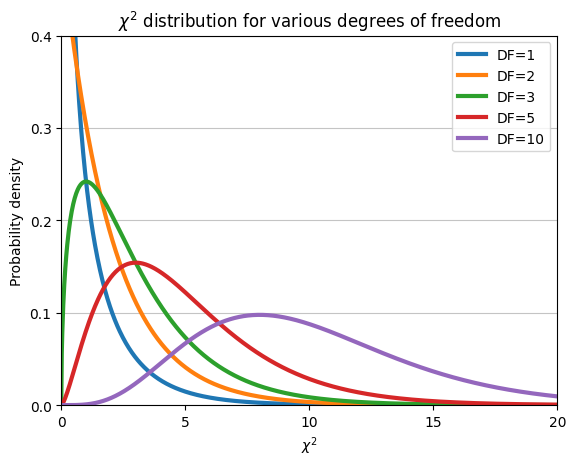

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import chi2

# Degrees of freedom to plot
degrees_of_freedom = [1, 2, 3, 5, 10]

# Generate x values for the distribution
x = np.linspace(0, 20, 1000)  # Range from 0 to 20 to capture most of the distribution

# Plot distributions for each degree of freedom
for df in degrees_of_freedom:
    plt.plot(x, chi2.pdf(x, df), label=f'DF={df}', lw=3)

# Add labels and title
plt.xlabel(r'$\chi^2$')
plt.ylabel('Probability density')
plt.title(r'$\chi^2$ distribution for various degrees of freedom')
plt.legend()

# Customize plot aesthetics
plt.grid(axis='y', alpha=0.75)
plt.xlim(0, 20)
plt.xticks([0, 5, 10, 15, 20])
plt.ylim(0, 0.4)
plt.yticks([0, .1, .2, .3, .4]);

The plot illustrates that the chi-squared distribution is right-skewed (long tail to the right). Moreover, as the degrees of freedom increase, the distribution becomes more symmetrical and approaches a normal distribution.

#### Degrees of freedom in goodness-of-fit tests

In a chi-squared goodness-of-fit test, the degrees of freedom are simply the number of categories minus 1. In the case of Mendel's pea experiment, there are 4 categories (round yellow, round green, wrinkled yellow, wrinkled green), so the degrees of freedom would be 3. They represent the number of categories whose frequencies can vary freely, given the constraint that the total number of observations is fixed. Once we know the frequencies of all but one category, the frequency of the remaining category is automatically determined.

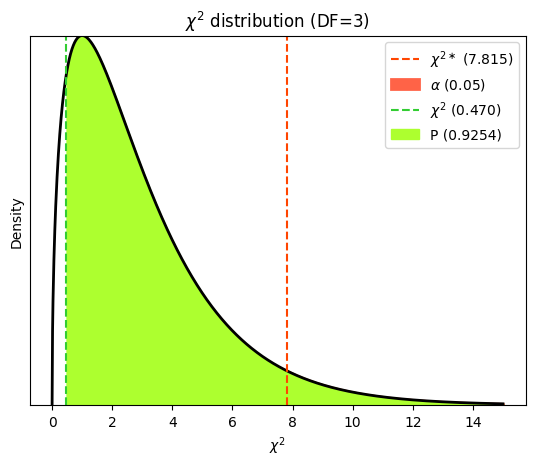

In [ ]:
# Degrees of freedom for Mendel's example
Df = 3

# Significance level (alpha)
alpha = 0.05

# Calculate critical value
chi2_crit = chi2.ppf(1 - alpha, df=Df)

# Calculate P value using chi-squared stat from previous calculation
p_value = 1 - chi2.cdf(chi2_stat, df=Df)

# Generate x values for plotting
x = np.linspace(0, 15, 1000)
hx = chi2.pdf(x, df=Df) 

# Create the plot
plt.plot(x, hx, lw=2, color="black")

# Plot the critical value
plt.axvline(
    x=chi2_crit, # type: ignore
    color='orangered',
    linestyle='--',
    label=fr'$\chi^{{2\ast}}$ ({chi2_crit:.3f})')

# Shade the probability alpha
plt.fill_between(
    x[x >= chi2_crit], hx[x >= chi2_crit],
    linestyle = "-", linewidth = 2, color = 'tomato',
    label=fr'$\alpha$ ({alpha})')

# Plot the observed chi-squared statistic
plt.axvline(
    x=chi2_stat,
    color='limegreen',
    linestyle='--',
    label=fr'$\chi^2$ ({chi2_stat:.3f})')

# Shade the P value area
plt.fill_between(
    x[x >= chi2_stat], hx[x >= chi2_stat],
    # hatch='///', edgecolor="limegreen", facecolor='lime', alpha=.5,
    color='greenyellow',
    label=f'P ({p_value:.4f})')

# Add labels and title
plt.xlabel(r'$\chi^2$')
plt.ylabel('Density')
plt.margins(x=0.05, y=0)
plt.yticks([])
plt.title(
    fr'$\chi^2$ distribution (DF={Df})')

plt.legend();

While the chi-squared goodness-of-fit test is inherently **one-tailed** due to the nature of the chi-squared distribution and test statistic, the interpretation can be either directional or non-directional depending on the specific hypothesis.

### Chi-squared test of independence

In this specific case, both seed shape and seed color have two categories each, resulting in a 2x2 (two rows by two columns) contingency table. The chi-squared test is often used to analyze 2x2 tables to determine if there is a significant association between the two categorical variables. Chi-squared tests can be applied to tables with more than two rows or columns, allowing us to analyze relationships between variables with multiple categories. In some cases, we might have a single row representing a categorical variable with multiple categories. We can still use the chi-squared test to compare the observed frequencies in each category to expected frequencies based on some theoretical distribution.

|              | Round seeds | Wrinkled seeds | Total |
| ------------ | ----------- | -------------- | ----- |
| Yellow seeds | 315         | 101            | 416   |
| Green seeds  | 108         | 32             | 140   |
| Total        | 423         | 133            | 556   |

#### Mosaic plot

The [`mosaic` function within the `statsmodels.graphics.mosaicplot` module](https://www.statsmodels.org/stable/generated/statsmodels.graphics.mosaicplot.mosaic.html) creates a mosaic plot, a powerful graphical representation of contingency tables that visualizes the relative frequencies of combinations of categories within a contingency table, the area of each rectangle in the plot being directly _proportional to the frequency_ of the corresponding category combination. Mosaic plots can effectively display relationships between multiple categorical variables, revealing hierarchical relationships between variables, and highlighting how the distribution of one variable changes depending on the levels of another variable.

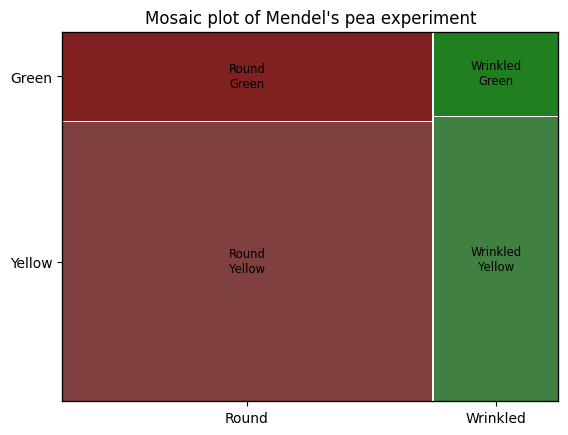

In [ ]:
from statsmodels.graphics.mosaicplot import mosaic

# Mendel's observed data (2x2 contingency table)
observed = np.array(
    [
        [315, 101],  # Yellow, round and wrinkled
        [108, 32]    # Green, round and wrinkled
    ])

# Create a DataFrame from the observed data
df = pd.DataFrame(
    observed,
    index=['Round', 'Wrinkled'],
    columns=['Yellow', 'Green'])

# Create a mosaic plot
mosaic(df.stack())  # Stacking the DataFrame for proper mosaic plot input
plt.title("Mosaic plot of Mendel's pea experiment");

#### Interpreting the results of the chi-squared test of independence

The [`scipy.stats.chi2_contingency` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html) performs the chi-squared test of independence for contingency tables. It's designed to assess whether there is a significant association between two categorical variables. It takes a contingency table (a 2D array or list of lists) as input, representing the observed frequencies of the categories. It returns the $\chi^2$ test statistic, the P value of the test, the degrees of freedom and the expected frequencies under the null hypothesis of independence.

The `chi2_contingency` function doesn't inherently know about Mendel's laws of inheritance or any specific biological mechanism. It calculates expected values based on a purely statistical assumption: independence between the categorical variables. The function first calculates the row and column totals of the observed contingency table. These totals represent the **marginal frequencies** of each category for each variable. It then calculates the expected proportion for each cell in the table under the assumption of independence. This is done by multiplying the corresponding row proportion and column proportion and dividing by the total number of observations. Finally, the expected frequencies are obtained by multiplying the expected proportions by the total number of observations.

In [ ]:
from scipy.stats import chi2_contingency

# Perform the chi-squared test of independence on the previous contingency table
chi2_stat, p_value, dof, expected = chi2_contingency(
    observed=observed,
    lambda_='pearson',  # could also use 'cressie-read', 'log-likelihood', 'neyman', etc.
    correction=True,    # Yates' correction for continuity
)

# Print the results
print("Observed Frequencies:")
print(observed)
print("\nExpected Frequencies (under null hypothesis of independence):")
print(expected.round(2)) # type: ignore
print("\nChi-Squared Statistic:", round(chi2_stat, 4)) # type: ignore
print("Degrees of Freedom:", dof)
print("P value:", round(p_value, 4)) # type: ignore

# Interpret the results (using alpha = 0.05 as significance level)
alpha = 0.05
if p_value < alpha: # type: ignore
    print("\nReject the null hypothesis. There is a significant \
association between seed shape and color.")
else:
    print("\nFail to reject the null hypothesis. \nThere is not enough \
evidence to suggest an association between seed shape and color.")

Observed Frequencies:
[[315 101]
 [108  32]]

Expected Frequencies (under null hypothesis of independence):
[[316.49  99.51]
 [106.51  33.49]]

Chi-Squared Statistic: 0.0513
Degrees of Freedom: 1
P value: 0.8208

Fail to reject the null hypothesis. 
There is not enough evidence to suggest an association between seed shape and color.


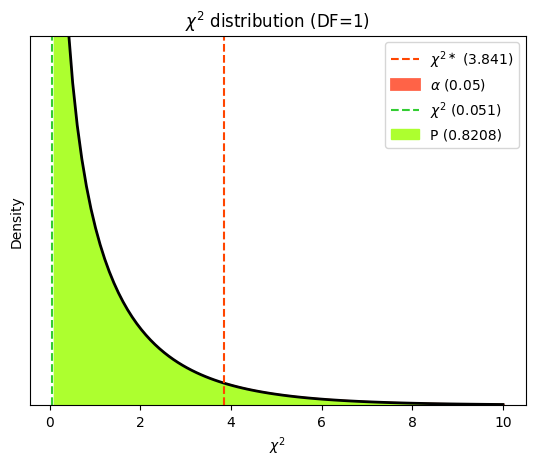

In [ ]:
# Degrees of freedom for Mendel's example
Df = dof

# Significance level (alpha)
alpha = 0.05

# Calculate critical value
chi2_crit = chi2.ppf(1 - alpha, df=Df)

# Calculate P value using chi-squared stat from previous calculation
p_value = 1 - chi2.cdf(chi2_stat, df=Df)

# Generate x values for plotting
x = np.linspace(0, 10, 100)
hx = chi2.pdf(x, df=Df) 

# Create the plot
plt.plot(x, hx, lw=2, color="black")

# Plot the critical value
plt.axvline(
    x=chi2_crit, # type: ignore
    color='orangered',
    linestyle='--',
    label=fr'$\chi^{{2\ast}}$ ({chi2_crit:.3f})')

# Shade the probability alpha
plt.fill_between(
    x[x >= chi2_crit], hx[x >= chi2_crit],
    linestyle = "-", linewidth = 2, color = 'tomato',
    label=fr'$\alpha$ ({alpha})')

# Plot the observed chi-squared statistic
plt.axvline(
    x=chi2_stat, # type: ignore
    color='limegreen',
    linestyle='--',
    label=fr'$\chi^2$ ({chi2_stat:.3f})')

# Shade the P value area
plt.fill_between(
    x[x >= chi2_stat], hx[x >= chi2_stat], # type: ignore
    # hatch='///', edgecolor="limegreen", facecolor='lime', alpha=.5,
    color='greenyellow',
    label=f'P ({p_value:.4f})')

# Add labels and title
plt.xlabel(r'$\chi^2$')
plt.ylabel('Density')
plt.margins(x=0.05, y=0)
plt.yticks([])
plt.ylim((0, .5))
plt.title(
    fr'$\chi^2$ distribution (DF={Df})')
plt.legend();

While the chi-squared test is widely used, it's important to be aware of its limitations and assumptions:

- Large sample size: the chi-squared test relies on _large-sample approximations_ to the **chi-squared distribution**. It's generally considered reliable when the expected frequencies in each cell of the contingency table are _at least 5_. For smaller sample sizes or sparse tables, Fisher's exact test might be a more appropriate choice.
- Independence: the observations in the contingency table must be **independent**. This means that each individual should contribute only one count to the table, and the occurrence of one event should not influence the occurrence of another event.

<u>Note:</u> when there are only two categories, the binomial test can compute exact P values without relying on large-sample approximations. This makes it particularly useful for small to moderate sample sizes. However, for very large sample sizes, computational considerations might make the normal approximation to the binomial distribution a more practical choice, as long as the conditions for this approximation are met.

#### Degrees of freedom in independence tests

In a chi-squared test of independence, the degrees of freedom represent the number of cells in the contingency table that can vary freely _once the marginal totals (row and column sums) are fixed_. It's a measure of how much flexibility or "wiggle room" the data has within the constraints of the fixed totals. For a contingency table with $r$ rows and $c$ columns, the degrees of freedom are calculated as $\text{DF} = (r - 1) * (c - 1)$.

In Mendel's pea experiment, while there are 4 phenotype categories, the underlying genetic model (his laws of inheritance) imposes constraints on how the data can be distributed. Once we know the total number of plants and the expected proportions based on Mendel's laws, we can determine the expected frequency for three of the cells. The fourth cell's expected frequency is then automatically determined to maintain the correct marginal totals.

We have a 2x2 table (2 rows for seed color and 2 columns for seed shape), so the degrees of freedom are 1. Imagine we have a 2x2 table with the marginal totals, once we fill in one cell, the rest of the cells are automatically determined due to the fixed marginal totals. We only _had the freedom_ to choose the value of one cell; the rest were constrained. Hence, the degrees of freedom in this case are 1.

The degrees of freedom in a chi-squared test reflect the number of independent pieces of information in the data that are available to estimate the parameters of interest.  It's not simply the number of categories, but rather the number of categories that can vary freely given the constraints imposed by the marginal totals and any underlying model.

#### Yates' correction

[Yates' correction](https://scirp.org/reference/referencespapers?referenceid=3172298) adjusts the chi-squared test statistic by _subtracting 0.5 from the absolute difference between observed and expected frequencies_ in each cell of the contingency table, making it a more conservative test and improving its accuracy for small sample sizes.

The chi-squared test relies on the assumption that the sampling distribution of the test statistic approximates a chi-squared distribution. However, this approximation can be inaccurate when dealing with small sample sizes or sparse contingency tables (where some expected frequencies are low). Yates' correction helps mitigate this issue by slightly reducing the chi-squared statistic, making it more closely match the theoretical chi-squared distribution under these conditions.

#### Directional hypothesis

The chi-squared test of independence is **not symmetrical** with respect to the rows and columns of the table, it typically has an _implicit directional hypothesis_. In Mendel's pea experiment, we were implicitly testing whether seed shape influences seed color (or vice versa). When we transpose the table, we're essentially reversing this directionality.

The expected frequencies calculated under the null hypothesis of independence change when we transpose the table. These expected frequencies are based on the marginal totals (row and column sums), which change when we swap rows and columns. The interpretation of the results can also be affected. If we transpose the table, we might be testing a different hypothesis than the original one.

Before performing the chi-squared test, clearly define the research question and hypothesis. This will help decide which variable should be represented by rows and which by columns in the contingency table. In some cases, it might be insightful to analyze both the original and transposed table to explore potential relationships in both directions.

In [ ]:
# Perform the chi-squared test of independence on the table transposed
chi2_stat, p_value, dof, expected = chi2_contingency(observed.T)

# Print the results
print("Observed Frequencies:")
print(observed.T)
print("\nExpected Frequencies (under null hypothesis of independence):")
print(expected.round(2)) # type: ignore
print("\nChi-Squared Statistic:", round(chi2_stat, 4)) # type: ignore
print("Degrees of Freedom:", dof)
print("P value:", round(p_value, 4)) # type: ignore

Observed Frequencies:
[[315 108]
 [101  32]]

Expected Frequencies (under null hypothesis of independence):
[[316.49 106.51]
 [ 99.51  33.49]]

Chi-Squared Statistic: 0.0513
Degrees of Freedom: 1
P value: 0.8208


#### Chi-squared independence tests using Pingouin

Let's illustrate a concrete example using [`pd.crosstab` to create a cross tabulation / contingency table](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html) from a [case study dataset on the heart diseases](https://link.springer.com/article/10.1007/s12046-018-0916-9) provided by Pingouin, and then analyze if gender is a good categorical predictor for the presence of heart disease using the [`chi2_independence` function from the Pingouin library](https://pingouin-stats.org/build/html/generated/pingouin.chi2_independence.html).

In [ ]:
import pingouin as pg
data = pg.read_dataset('chi2_independence')

print("DataFrame's head:\n", data.head())
print("\n---------------------------------")
print("Contingency table:\n", pd.crosstab(data['sex'], data['target']))

DataFrame's head:
    age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1  

---------------------------------
Contingency table:
 target    0   1
sex            
0        24  72
1       114  93


In [ ]:
# Perform chi-squared test using pingouin
expected, observed, stats = pg.chi2_independence(
    data,
    x='sex', y='target',
    correction=False,  # No Yates' correction for illustration
)

# Print the results
print("Observed Frequencies:")
print(observed)
print("\nExpected Frequencies (under null hypothesis of independence):")
print(expected.round(2))
print("\nChi-Squared Statistic:")
pg.print_table(stats.round(4))

Observed Frequencies:
target    0   1
sex            
0        24  72
1       114  93

Expected Frequencies (under null hypothesis of independence):
target      0       1
sex                  
0       43.72   52.28
1       94.28  112.72

Chi-Squared Statistic:
test                  lambda    chi2    dof    pval    cramer    power
------------------  --------  ------  -----  ------  --------  -------
pearson                1.000  23.914  1.000   0.000     0.281    0.998
cressie-read           0.667  24.149  1.000   0.000     0.282    0.998
log-likelihood         0.000  24.841  1.000   0.000     0.286    0.999
freeman-tukey         -0.500  25.576  1.000   0.000     0.290    0.999
mod-log-likelihood    -1.000  26.526  1.000   0.000     0.296    0.999
neyman                -2.000  29.205  1.000   0.000     0.310    1.000



The output from `pingouin.chi2_independence` includes the chi-squared statistic, degrees of freedom, and P value for each test. A small P value (typically < 0.05) indicates evidence against the null hypothesis of independence, suggesting a statistically significant association between the variables. A larger chi-squared value generally indicates a stronger association, but its magnitude should be interpreted in conjunction with the degrees of freedom.

`pingouin.chi2_independence` doesn't just perform the standard Pearson's chi-squared test. It actually computes several related chi-squared tests, each with slightly different theoretical underpinnings and assumptions. This allows us to compare the results of different tests and choose the one most appropriate for the specific data and analysis goals.

1. Pearson's chi-squared test (`pearson`): this is the classic chi-squared test of independence that we're likely most familiar with. It compares the observed frequencies in the contingency table to the expected frequencies under the null hypothesis of independence. It's the most commonly used chi-squared test and is generally suitable for most situations.
2. Cressie-Read power divergence statistic (`cressie-read`): this is a family of chi-squared statistics that includes Pearson's chi-squared as a special case (when the lambda parameter is 1). By varying the lambda parameter, we can adjust the test's sensitivity to different types of deviations from independence. Pingouin calculates this statistic for several lambda values (2/3, 0, -1/2, -1, -2), allowing us to compare the results.
3. Log-likelihood ratio test (`log-likelihood`): this test compares the likelihood of the observed data under the null hypothesis of independence to the likelihood under a model where the variables are allowed to be associated. It's an alternative to the Pearson chi-squared test and is often preferred for smaller sample sizes.
4. Freeman-Tukey statistic (`freeman-tukey`): this test is similar to the Pearson chi-squared, but it uses a variance-stabilizing transformation to make the test statistic more closely follow a chi-squared distribution, particularly for small sample sizes.
5. Neyman modified chi-squared (`neyman`): this test is another modification of the Pearson chi-squared test that aims to improve its performance for small sample sizes or sparse tables.

## Cochran-Armitage test for trend

While the chi-squared test assesses general associations between _categorical variables_, the [Cochran-Armitage trend test (also known as the trend test)](https://en.wikipedia.org/wiki/Cochran%E2%80%93Armitage_test_for_trend) is a specialized tool designed to detect linear trends in proportions across **ordinal categories**. This test is particularly valuable in biostatistics, especially in toxicology and dose-response studies, where we often want to determine if there's a relationship between increasing doses or exposure levels and the probability of a specific outcome.

### How the trend test works

The trend test essentially assigns scores to each category of the ordinal variable (e.g., 1, 2, 3 for low, medium, high dose) and then calculates a weighted chi-squared statistic. This weighted statistic takes into account the ordering of the categories, making it sensitive to linear trends.

The trend test is most appropriate when:

- Ordinal categories: the data involves a binary outcome (e.g., presence/absence of disease) and an explanatory variable with ordered categories (e.g., increasing dose levels: low, medium, high).
- Linear trend suspected: we suspect that the proportion of the outcome changes in a linear fashion across the ordered categories. For example, we might hypothesize that the risk of disease increases with higher doses of a toxin.

The trend test is more powerful than the standard chi-squared test when a linear trend truly exists. This means it's more likely to detect a real association when one is present. Moreover, it specifically tests for a linear trend, making it more focused than the general chi-squared test, which only assesses whether there's any association. Finally, the trend test is ideally suited for dose-response studies, where the goal is to understand how the effect of a substance changes with increasing exposure levels.

Note that the Cochran-Armitage test assumes that the trend is consistent across dose groups (i.e., the effect of each dose increment is roughly the same).

### Example of varying the dose of a drug

We will use the (two-sided) Cochran-Armitage trend test in Python with [`statsmodels.stats.contingency_tables.Table.test_ordinal_association`](https://www.statsmodels.org/dev/generated/statsmodels.stats.contingency_tables.Table.test_ordinal_association.html). Let's assume we have the following data from a toxicology study, where we exposed different groups of animals to increasing doses of a test article (TA) and recorded the number of tumors:

|                        | 0 dose (control) | 1 dose (low) | 2 doses (medium) | 3 doses (high) |
| ---------------------- | ---------------- | ------------ | ---------------- | -------------- |
| Animals with tumor     |         0        |       1      |         3        |        6       |
| Total animals examined |        50        |      50      |        50        |       50       |

Note that in this example, the total number of animals per dose group is the same. This does not have to be the case for the Cochran-Armitage test.

#### `Table` vs. `Table2x2`

Note the [distinction between `statsmodels.Table` and `statsmodels.Table2x2`](https://www.statsmodels.org/stable/contingency_tables.html):

- [`statsmodels.Table`](https://www.statsmodels.org/stable/generated/statsmodels.stats.contingency_tables.Table.html#statsmodels.stats.contingency_tables.Table):
    - General purpose: this class is designed for working with contingency tables of _any size_ (i.e., tables with more than two rows and/or columns).
    - Functionality: it offers a wide range of methods for analyzing contingency tables, including:
        - Chi-squared test of independence
        - Fisher's exact test
        - Measures of association (e.g., Cramer's V, contingency coefficient)
        - Tests for marginal homogeneity
        - Calculation of expected frequencies, residuals, etc.
    - Flexibility: it can handle various types of input data, including raw data arrays, frequency counts, and proportions.
    - When to use: choose `Table` when we have a contingency table that is not strictly 2x2 and need to perform a variety of analyses.
- [`statsmodels.Table2x2`](https://www.statsmodels.org/stable/generated/statsmodels.stats.contingency_tables.Table2x2.html#statsmodels.stats.contingency_tables.Table2x2):
    - Specialized for 2x2 tables: as the name suggests, this class is specifically tailored for analyzing 2x2 contingency tables (tables with two rows and two columns).
    - Focused functionality: it provides a set of methods optimized for 2x2 tables, including:
        - Odds ratio and relative risk estimation
        - Confidence intervals for OR, RR, and risk difference
        - McNemar's test for paired data
        - Various tests of marginal homogeneity
    - Convenience: it offers a streamlined interface for common analyses on 2x2 tables.
    - When to use: choose `Table2x2` when we have a 2x2 contingency table and need to perform the specific analyses it offers.

#### Interpreting the results of the Cochran-Armitage test

The choice of scores can influence the test results. In `statsmodels.Table.test_ordinal_association`, the `col_scores` argument allows to specify the scores assigned to each column (category) of the contingency table. The direction of the trend (increasing or decreasing) is determined by the order of the scores. If the scores increase from left to right, the test will assess if there's an increasing trend (default method behavior). If the scores decrease from left to right, the test will look for a decreasing trend.

In the context of a toxicology study, where we're interested in the potential harmful effects of a treatment, a significant *increasing trend* in tumor rates (one-sided test) with increasing dose is a concerning finding. It suggests that the treatment might be promoting tumor development, and further investigation is needed to assess the safety and potential risks associated with the treatment.

In [ ]:
from statsmodels.stats.contingency_tables import Table

# Sample data: Tumor counts (rows) by Dose groups (columns)
dose_groups = ['Control', 'Low', 'Medium', 'High']
tumor_counts = np.array([
    [0, 50],  # Control group
    [1, 49],  # Low dose (1 tumor out of 50 total animals)
    [3, 47],  # Medium dose
    [6, 44]   # High dose
])

# Perform Cochran-Armitage Trend Test
result = Table(tumor_counts, shift_zeros=False).test_ordinal_association(
    # row_scores=np.array([0, 1, 2, 3]),  # default
    col_scores=np.array([1, 0]),  # reversed trend
)

print(result)

# Extract P value
p_value = result.pvalue / 2  # Divide p-value by 2 for one-sided test

# Interpret results
alpha = 0.05
if p_value < alpha:
    print(
        f"\nReject the null hypothesis (P = {p_value:.3f}; one-sided test).\
\nThere is a significant increasing trend in tumor rates with increasing dose.")
else:
    print(
        f"\nFail to reject the null hypothesis (P = {p_value:.3f}; one-sided test).\
\nThere is not enough evidence to suggest a trend.")

null_mean   15.0
null_sd     3.454659660058306
pvalue      0.0037959220933673713
statistic   25.0
zscore      2.894641146743591

Reject the null hypothesis (P = 0.002; one-sided test).
There is a significant increasing trend in tumor rates with increasing dose.


Be aware that the `statsmodels.Table` class, used for analyzing contingency tables, has a default behavior of adding 0.5 to _zero cell counts_ if the `shift_zeros` argument is set to `True` (which is the default). This is done to avoid potential issues with zero frequencies when calculating statistics like the chi-squared test statistic. However, other statistical software or functions might not have this default behavior, potentially leading to different results if they encounter zero frequencies.

In [ ]:
print(
    Table(
        tumor_counts,
    ).test_ordinal_association(
        # row_scores=np.array([0, 1, 2, 3]),  # default
        col_scores=np.array([1, 0])  # reversed trend
    )
)

null_mean   15.71072319201995
null_sd     3.5390390971784127
pvalue      0.008669937476153359
statistic   25.0
zscore      2.624801973899118


The `test_ordinal_association` method from `statsmodels.stats.contingency_tables.Table` in Python performs the Cochran-Armitage test for trend. This test assesses whether there is a linear trend in the proportions of observations across ordered categories. It relies on an *asymptotic approximation* using the chi-squared distribution, which is generally accurate for large sample sizes.

For more sophisticated trend analysis or situations with small sample sizes, [alternative methods are available in R](https://rcompanion.org/handbook/H_09.html). For example, the `coin` package provides a flexible framework for permutation-based tests, including the linear-by-linear association test (`lbl_test`) and other trend tests. These permutation tests can be more accurate when the assumptions of the chi-squared test are not met or when dealing with small sample sizes. We can also use different scoring systems to test for linear, quadratic, or other types of trends.

In [2]:
library(coin)  # https://cran.r-project.org/web/packages/coin/index.html

table <- matrix(c(0,1,3,6,50,49,47,44), byrow=TRUE, nrow=2, dimnames=list(resp=c(1,0), dose=0:3))

lbl_test(as.table(table))

Le chargement a nécessité le package : survival




	Asymptotic Linear-by-Linear Association Test

data:  dose (ordered) by resp (1, 0)
Z = 2.8946, p-value = 0.003796
alternative hypothesis: two.sided


In [3]:
# Perform the Cochran-Armitage test using independence_test with 'exact' distribution
coin::independence_test(
    as.table(table),
    # distribution = 'asymptotic',  # same as lbl_test()
    distribution = "exact",
    ytrafo = function(data) {
        trafo(
            data,
            factor_trafo = function(x) {
                model.matrix(~ x - 1) %*% as.numeric(colnames(table))
            }
        )
    }
)


	Exact General Independence Test

data:  dose by resp (1, 0)
Z = 2.8946, p-value = 0.004433
alternative hypothesis: two.sided


## Case-control studies

In the previous sections, we've explored methods for analyzing data from cross-sectional and prospective studies, where we often have access to incidence rates or risk information directly. Case-control studies, however, present a different paradigm. These studies are **retrospective**, meaning they start with individuals who already have the outcome of interest (cases) and those who don't (controls). The goal is to look back in time to assess whether exposure to a particular risk factor differs between the two groups. Though, they are prone to certain biases, such as recall bias (cases might remember their exposure history differently than controls) and selection bias (the way cases and controls are selected might not be representative of the underlying population).

### Statistical analysis in case-control studies

Unlike cohort studies, case-control studies are designed retrospectively, starting with individuals who already have the disease (cases) and those who don't (controls). This structure means that the proportion of cases in the study doesn't reflect the true disease prevalence in the population. Consequently, we cannot directly calculate risks or relative risks (RR) from case-control data.

Instead, case-control studies utilize the odds ratio (OR) as their primary measure of association. The OR compares the odds of exposure (e.g., vaccination) among cases to the odds of exposure among controls.  Mathematically, it's the ratio of the odds of cases being exposed to the odds of controls being exposed.

The statistical tools we've discussed so far are still relevant, but their interpretation and application need to be adapted for case-control designs:

- Fisher's exact test can still be used in case-control studies, especially when the sample size is _small_ or the contingency table has low expected frequencies. However, it's important to remember that Fisher's test provides a P value for testing the null hypothesis of no association, but it doesn't directly estimate the relative risk.
- For larger sample sizes, the chi-squared test can be used as an alternative to Fisher's exact test for testing the association between the exposure and outcome in a case-control study. Again, the chi-squared test doesn't directly provide the RR, but it does give a P value to assess statistical significance.
- The Cochran-Armitage test is generally not applicable to case-control studies because it's designed for prospective studies where we follow individuals over time to observe the development of an outcome. In case-control studies, we're looking back in time at exposure history, not tracking the development of new cases.

### Cholera vaccination example

Case-control studies offer a powerful tool in epidemiology to explore the relationship between potential risk factors (exposures) and disease outcomes. They are particularly useful when studying rare diseases or outcomes with long latency periods, as they are often more efficient than prospective cohort studies.

The results of a case-control study are typically organized into a contingency table, where rows represent the outcome (case or control), columns represent the exposure (vaccinated or not vaccinated), and cell values represent the number of individuals in each category combination.

Let's consider a classic example: investigating whether cholera vaccination is associated with a reduced risk of developing cholera, like in the [study on oral cholera vaccination from Lucas and colleagues](https://pubmed.ncbi.nlm.nih.gov/15728808/). In this case-control study:

- Cases: individuals who have contracted cholera.
- Controls: individuals from the same population who have not contracted cholera.

We would then determine whether each individual in both groups had been previously vaccinated against cholera. The data could be organized in a contingency table like the one we saw earlier:

| Vaccine | Cases (cholera) | Controls |
| ------- | --------------- | -------- |
| Yes     |       10        |    94    |
| No      |       33        |    78    |

In [ ]:
# Create the contingency table from the data
data = [
    [10, 94],
    [33, 78]
]
table = Table2x2(data)

# Calculate the odds ratio (OR) and the 95% confidence interval
oddsratio = table.oddsratio
ci = table.oddsratio_confint()

print(f"Odds Ratio (OR): {oddsratio:.3f}")
print(f"95% Confidence Interval for OR: {tuple(round(bound, 3) for bound in ci)}")

Odds Ratio (OR): 0.251
95% Confidence Interval for OR: (0.117, 0.542)


The odds ratio quantifies the association between the vaccine (exposure) and the case/control status (outcome).

- An OR greater than 1 indicates that the exposure (vaccine) is associated with higher odds of being a case (having the disease).
- An OR less than 1 indicates that the exposure (vaccine) is associated with lower odds of being a case (having the disease), suggesting a protective effect.
- An OR of 1 means there's no association between the exposure and the outcome.

In our example, the OR of 0.25 signifies that vaccinated individuals have only 25% of the odds of developing the disease compared to unvaccinated individuals. This translates to a 75% reduction in the odds of disease due to vaccination.

Interestingly, the odds ratio often serves as a good approximation of the relative risk (RR) in many scenarios. This approximation is particularly accurate when the disease is rare. However, recent research suggests that the OR can be reasonably interpreted as the RR in most case-control studies, even for common diseases, with some caveats and careful consideration of the study design.

Moreover, the 95% confidence interval provides a range within which we can be 95% confident that the true population odds ratio lies. If the CI does not include 1, it indicates a _statistically significant_ association at the 5% significance level.

Given the relatively small sample sizes in this case-control study, we might consider performing Fisher's exact test in addition to calculating the OR and CI. This test is more appropriate for small samples and will provide an exact P value for the association.

In [ ]:
oddsratio, p_value = fisher_exact(data)

print("Fisher's Exact Test P value:", round(p_value, 4)) # type: ignore

Fisher's Exact Test P value: 0.0003


### Isotretinoin and bowel disease

Let's use the example data on isotretinoin use and inflammatory bowel disease (IBD) in the [case-control study from Bernstein and colleagues](https://pubmed.ncbi.nlm.nih.gov/19623167/) to demonstrate a scenario where the confidence interval for the odds ratio (OR) includes 1, indicating a lack of statistically significant association.

| Isotretinoin | Cases (IBD) | Controls |
| ------------ | ----------- | -------- |
| Yes          |      25     |   213    |
| No           |    1935     |  19216   |

In [ ]:
# Create the contingency table from the data
data = [
    [25, 213],
    [1935, 19216]
]
table = Table2x2(data)

print(table.summary())

               Estimate   SE   LCB    UCB  p-value
--------------------------------------------------
Odds ratio        1.166        0.768 1.769   0.471
Log odds ratio    0.153 0.213 -0.264 0.570   0.471
Risk ratio        1.148        0.791 1.668   0.468
Log risk ratio    0.138 0.190 -0.235 0.511   0.468
--------------------------------------------------


The OR of 1.149 suggests that individuals exposed to isotretinoin have 1.149 times the odds of having IBD compared to those not exposed. However, this value is close to 1, indicating a weak association. Moreover, the 95% CI for the OR ranges from 0.768 to 1.769. Importantly, this interval includes 1. This means that we cannot rule out the possibility of no association between isotretinoin use and IBD in the population. We fail to reject the null hypothesis of no association at the 5% significance level.

Given the large sample size in this example, the chi-squared test could also be used to assess the association. However, Fisher's exact test might be preferred if any of the cell counts were small.

In [ ]:
chi2, p, dof, ex = chi2_contingency(data, correction=False)

print("Chi-squared test P value:", round(p, 3)) # type: ignore

Chi-squared test P value: 0.471


In [ ]:
oddsratio, p_value = fisher_exact(data)

print("Fisher's exact test P value:", round(p_value, 3)) # type: ignore

Fisher's exact test P value: 0.431


While the association is not statistically significant, it's important to consider the potential clinical implications of even a small increased risk, especially for a drug with known side effects. Further research with larger sample sizes or different study designs might be warranted to clarify the relationship. The lack of statistical significance could be due to various factors, including limited sample size, potential biases in the study design, or the presence of confounding variables.

## Conclusion

In this chapter, we've embarked on a journey through the world of comparing proportions—a cornerstone of biostatistical analysis. We've explored a wide array of tools and techniques, from foundational contingency tables to powerful statistical tests, each designed to unveil patterns and associations hidden within categorical data.

We began with Fisher's exact test, a precise method for analyzing small sample sizes and rare events. We then delved into the versatile chi-squared test, capable of handling larger tables and assessing deviations from expected frequencies. We further refined our toolkit with the Cochran-Armitage trend test, designed to detect trends in ordinal data, particularly useful in toxicological studies.

Along the way, we explored essential concepts like attributable risk, relative risk, odds ratio, and number needed to treat (NNT), equipping us with the language and understanding to quantify the impact of exposures and treatments. We learned how to construct confidence intervals for these measures, acknowledging and embracing the uncertainty inherent in statistical estimation.

Finally, we turned our attention to case-control studies, a powerful observational design for exploring associations in retrospective data. We discovered the importance of the odds ratio in this context and how it can approximate the relative risk under certain conditions.

Throughout this chapter, we've emphasized the importance of selecting the right statistical tool for the job. The choice of test depends on the study design, data characteristics, and research questions. While some tests are more versatile than others, each has its own strengths and limitations. Understanding these nuances is crucial for conducting rigorous and reliable analyses. For example, smaller sample sizes might require exact tests (like Fisher's) or adjustments (like Yates' correction), while larger samples can often rely on approximations (like the chi-squared test).

We've learned how to harness the power of Python to perform these analyses, using libraries like `scipy.stats` and `statsmodels`. We've seen how these tools can be applied to real-world problems, from assessing the efficacy of treatments to analyzing dose-response relationships in toxicology studies.

As we conclude this chapter, it's crucial to remember that statistics are more than just numbers. They are lenses through which we interpret data, helping us make sense of complex phenomena and inform decision-making. However, statistical results should always be interpreted in context.

## Cheat sheet

This cheat sheet provides a quick reference for essential code snippets used in this chapter.

### Contingency table

```python
import numpy as np
from scipy.stats import contingency

# Example data
treatment = np.array([1, 1, 2, 2, 1, 2, 1])
outcome   = np.array([0, 1, 0, 1, 1, 1, 0])

# Create contingency table with scipy.stats.contingency
res = contingency.crosstab(treatment, outcome) # treatment will be the rows, outcome the columns
table = res.count

# If the data is already in a Pandas DataFrame we can use pandas.crosstab
import pandas as pd
# Assuming the Dataframe has columns named "treatment" and "outcome"
df = pd.DataFrame({"treatment": treatment, "outcome": outcome})

# Creating contingency table using pd.crosstab
table = pd.crosstab(
    df["treatment"].dropna(),  # Remove NaN values if expected
    df["outcome"],
    margins=True,     # Include row and column totals
    dropna=False      # Keep rows/columns with zero counts
)

# # Pre-aggregated contingency table with rows = alternative treatments,
# cols = alternative outcomes; here is the example from Apixaban study
table_df = pd.DataFrame(
    {
        'recurrence':    [73, 14],
        'no_recurrence': [756, 826],
    },
    index=['placebo', 'apixaban'])
```

### Fisher's exact test

```python
from scipy.stats import fisher_exact

# Assuming 'table' is (pre-aggregated) 2x2 contingency table (NumPy array or list of lists)
table = table_df.to_numpy() # converts DataFrame to NumPy array
odds_ratio, p_value = fisher_exact(table, alternative='two-sided')
# could use `alternative='greater'` for toxicology count data
```

### Risk and odds ratio analysis

```python
from statsmodels.stats.contingency_tables import Table2x2

# Assuming 'table' is the 2x2 contingency table (NumPy array)
table2x2 = Table2x2(table_df.to_numpy())
# Calculate and print the results
print(table2x2.summary())

# Calculates probabilities
a, b, c, d = table_df.to_numpy().ravel()
p1, p2 = a / (a + b), c / (c + d)
# Confidence intervals
from statsmodels.stats.proportion import proportion_confint
conf=0.95  # Set 95% confidence interval
ci_p1 = proportion_confint(count=a, nobs=a+b, alpha=1-conf, method='normal')
ci_p2 = proportion_confint(count=c, nobs=c+d, alpha=1-conf, method='normal')

# Overall risk
p_bar = (a + c) / (a + b + c + d)

# Calculates absolute risk reduction / attributable risk
arr = p1 - p2
# Confidence interval estimation
from statsmodels.stats.proportion import confint_proportions_2indep
ci_arr_1, ci_arr_2 = confint_proportions_2indep(
    count1=a,
    nobs1=a+b,
    count2=c,
    nobs2=c+d,
    compare='diff',
    method='score',  # ['wald', 'agresti-caffo', 'newcomb', 'score']
    alpha=0.05)

# Calculates number needed to treat
ntt = 1/arr
# Confidence interval is the reciprocal of ARR CI
ci_ntt_1 = round(1/ci_arr_2)
ci_ntt_2 = round(1/ci_arr_1)

# Calculates relative risk
rr = p1/p2
# Alternatively using scipy.stats.contingency
contingency.relative_risk(
    exposed_cases=a,
    exposed_total=a+b,
    control_cases=c,
    control_total=c+d
).relative_risk
# Confidence interval estimation
ci_rr_1, ci_rr_2 = confint_proportions_2indep(
    count1=a,
    nobs1=a+b,
    count2=c,
    nobs2=c+d,
    compare='ratio',
    method='score',  # ['log', 'log-adjusted', 'score']
    alpha=0.05)

# Calculates odds ratio
or = a*d / (b*c)
# Alternatively using scipy.stats.contingency
contingency.odds_ratio(
    table=table_df.to_numpy(),
    kind='sample').statistic
# Confidence interval estimation
ci_or_1, ci_or_2 = confint_proportions_2indep(
    count1=a,
    nobs1=a+b,
    count2=c,
    nobs2=c+d,
    compare='odds-ratio',
    method='score',  # ['logit', 'logit-adjusted', 'score']
    alpha=0.05)
```

### Z-test

```python
from statsmodels.stats.proportion import proportions_ztest

# Extract counts and total observations for each group from the Apixaban table
count = table_df['recurrence']
nobs = table_df.sum(axis=1)

# Perform Z-test for difference in proportions
z_stat, p_value = proportions_ztest(count, nobs)
```

### Chi-squared goodness-of-fit test

```python
from scipy.stats import chisquare

# Mendel's observed data
observed = np.array([315, 108, 101, 32])

# Mendel's expected proportions (here as fractions)
expected_proportions = np.array([9/16, 3/16, 3/16, 1/16])

# Perform the chi-squared goodness-of-fit test
chisquare(
    f_obs=observed,
    f_exp=observed.sum() * expected_proportions)
```

### Chi-squared distribution

```python
from scipy.stats import chi2

# Define the standard normal distribution model
df = 5
chi2_distribution = chi2(df=df)
# Distribution statistics
chi2_distribution.stats()

# Probabilities
# Cumulative Distribution Function - P(X<=8)
chi2_distribution.cdf(x=8)
# (One-tailed) Survival Function - P(X>=16)
chi2_distribution.sf(x=16)
# Percent Point Function
chi2_distribution.ppf(q=.95)
```

### Chi-squared test of independence

```python
# Mendel's observed data (2x2 contingency table)
observed = np.array(
    [
        [315, 101],  # Yellow, round and wrinkled
        [108, 32]    # Green,  round and wrinkled
    ])

# Create a DataFrame from the observed data
df = pd.DataFrame(
    observed,
    index=['Round', 'Wrinkled'],
    columns=['Yellow', 'Green'])

# Create a mosaic plot
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic
mosaic(df.stack())  # Stacking the DataFrame for proper mosaic plot input

from scipy.stats import chi2_contingency

# Perform the chi-squared test of independence on the previous contingency table
chi2_contingency(
    observed=observed,
    lambda_='pearson',  # ['log-likelihood', 'freeman-tukey', 'neyman', 'cressie-read']
    correction=True,    # Yates' correction for continuity
)

# Chi-squared independence tests using pingouin
import pingouin as pg
pg.chi2_independence(
    data=table_df,
    x='recurrence', y='no_recurrence',
    correction=False)
```

### Cochran-Armitage test for trend

```python
from statsmodels.stats.contingency_tables import Table

# Sample data: Tumor counts (rows) by Dose groups (columns)
dose_groups = ['Control', 'Low', 'Medium', 'High']
tumor_counts = np.array([
    [0, 50],  # Control group
    [1, 49],  # Low dose (1 tumor out of 50 total animals)
    [3, 47],  # Medium dose
    [6, 44]   # High dose
])

# Perform Cochran-Armitage trend test (asymptotic linear-by-linear)
print(
    Table(
        tumor_counts,
        shift_zeros=False
    ).test_ordinal_association(
        # row_scores=np.array([0, 1, 2, 3]), # default
        col_scores=np.array([1, 0])   # reversed trend
    ))
# Divide p-value by 2 for one-sided test
```

```R
table <- matrix(c(0,1,3,6,50,49,47,44), byrow=TRUE, nrow=2, dimnames=list(resp=c(1,0), dose=0:3))

# https://cran.r-project.org/web/packages/coin/index.html
library(coin)
lbl_test(as.table(table))

coin::independence_test(
    as.table(table),
    # distribution = 'asymptotic',  # same as lbl_test()
    distribution = 'exact',
    ytrafo = function(data) {
        trafo(
            data,
            factor_trafo = function(x) {model.matrix(~ x - 1) %*% as.numeric(colnames(table))}
        )
    }
)
```

### Case-control studies

```python
# Create the contingency table from the data
data = [
    [25, 213],
    [1935, 19216]
]
table = Table2x2(data)
print(table.summary())

chi2_contingency(data)
```

## Session information

The output below details all packages and version necessary to reproduce the results in this report.

In [ ]:
!python --version
print("-------------")

from importlib.metadata import version

# List of packages we want to check the version
packages = ['numpy', 'pandas', 'matplotlib', 'seaborn', 'scipy', 'pingouin', 'statsmodels']

# Initialize an empty list to store the versions
versions = []

# Loop over the packages
for package in packages:
    try:
        # Get the version of the package
        package_version = version(package)
        # Append the version to the list
        versions.append(package_version)
    except Exception:  # Use a more general exception for broader compatibility
        versions.append('Not installed')

# Print the versions
for package, version in zip(packages, versions):
    print(f'{package}: {version}')

Python 3.12.7
-------------
numpy: 1.26.4
pandas: 2.2.2
matplotlib: 3.9.2
seaborn: 0.13.2
scipy: 1.14.1
pingouin: 0.5.5
statsmodels: 0.14.2


In [ ]:
sessionInfo()

NameError: name 'sessionInfo' is not defined